In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from scipy.stats import skew, boxcox, pearsonr

In [231]:
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn_pandas import DataFrameMapper, gen_features

### case study: cell segmentaltion in High-Content Screening

In [181]:
data = pd.read_csv('datasets/segmentationOriginal/segmentationOriginal.csv', index_col=0)

In [5]:
data.head()

,Cell,Case,Class,AngleCh1,AngleStatusCh1,AreaCh1,AreaStatusCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,...,VarIntenCh1,VarIntenCh3,VarIntenCh4,VarIntenStatusCh1,VarIntenStatusCh3,VarIntenStatusCh4,WidthCh1,WidthStatusCh1,XCentroid,YCentroid
1,207827637,Test,PS,143.247705,1,185,0,15.711864,3.954802,9.548023,...,12.474676,7.609035,2.714100,0,2,2,10.642974,2,42,14
2,207932307,Train,PS,133.752037,0,819,1,31.923274,205.878517,69.916880,...,18.809225,56.715352,118.388139,0,0,0,32.161261,1,215,347
3,207932463,Train,WS,106.646387,0,431,0,28.038835,115.315534,63.941748,...,17.295643,37.671053,49.470524,0,0,0,21.185525,0,371,252
4,207932470,Train,PS,69.150325,0,298,0,19.456140,101.294737,28.217544,...,13.818968,30.005643,24.749537,0,0,2,13.392830,0,487,295
5,207932455,Test,PS,2.887837,2,285,0,24.275735,111.415441,20.474265,...,15.407972,20.504288,45.450457,0,0,0,13.198561,0,283,159


In [6]:
data.shape

(2019, 119)

In [226]:
train = data.loc[data.Case=='Train', 'Class':]
test = data.loc[data.Case=='Test', 'Class':]

train.shape, test.shape

((1009, 117), (1010, 117))

In [236]:
# binary version of original predictors
num_cols = train.columns[~train.columns.str.contains('Status')][1:]
train_num = train[num_cols]
train_num.shape

(1009, 58)

In [244]:
# skewness for each numeric columns
skew_feats = pd.Series(skew(train_num.values), index=train_num.columns)

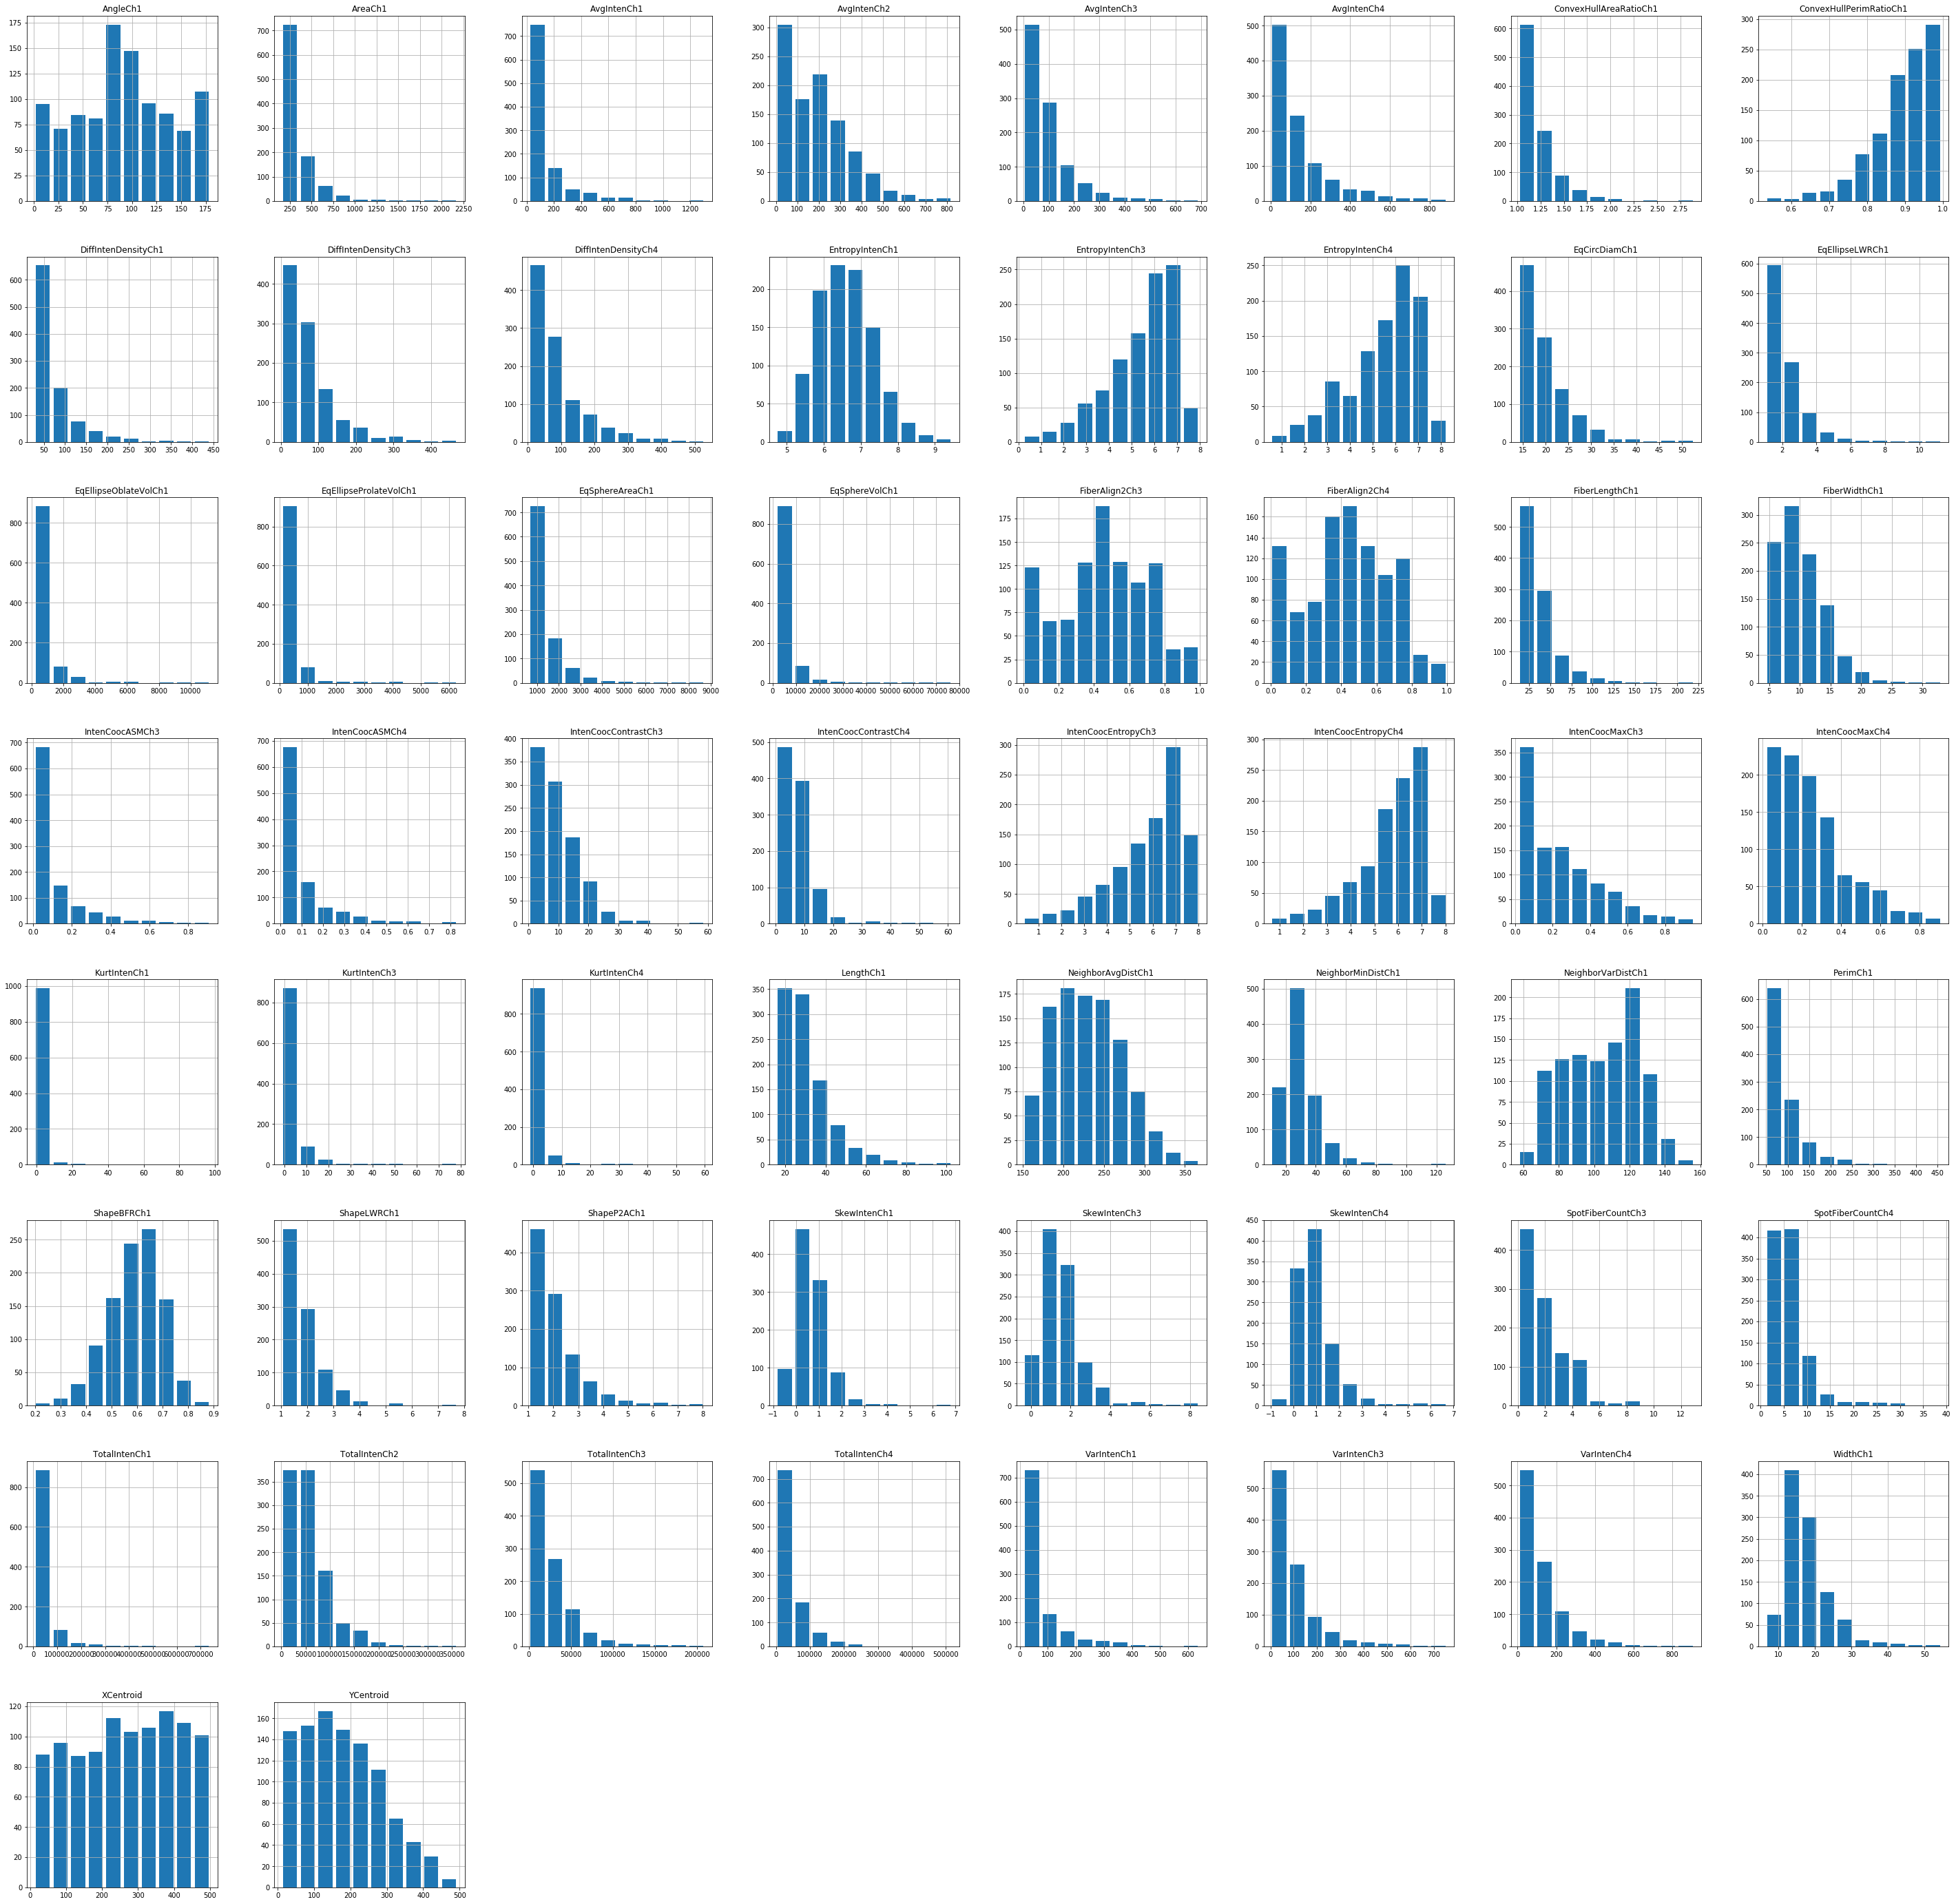

In [240]:
_ = train_num.hist(rwidth=.8, figsize=(50, 50))

In [246]:
a, lam = boxcox(train_num.AreaCh1.values)
skew_feats['AreaCh1'], lam

(3.5303544460710063, -0.85586872223451771)

In [243]:
train_num.AreaCh1.describe()

count    1009.000000
mean      325.125867
std       216.555276
min       150.000000
25%       194.000000
50%       256.000000
75%       376.000000
max      2186.000000
Name: AreaCh1, dtype: float64

In [251]:
a = pd.Series(a, index=train_num.index)
a.describe()

count    488.000000
mean       1.158283
std        0.003493
min        1.152366
25%        1.155463
50%        1.158046
75%        1.161036
max        1.166784
dtype: float64

In [252]:
train_num.AreaCh1[:5]

2     819
3     431
4     298
12    256
15    258
Name: AreaCh1, dtype: int64

In [253]:
a[:5]

2     1.159491
3     1.158254
4     1.158321
12    1.154138
15    1.153922
dtype: float64

In [10]:
int_cols = [c for c in train.columns if train[c].dtype==int]

float_cols = [c for c in train.columns if train[c].dtype==float]

In [11]:
train.loc[:, int_cols].applymap(str).describe(include=['O']).T

,count,unique,top,freq
AngleStatusCh1,1009,3,0,630
AreaCh1,1009,399,156,13
AreaStatusCh1,1009,2,0,927
AvgIntenStatusCh1,1009,2,0,805
AvgIntenStatusCh2,1009,3,0,622
AvgIntenStatusCh3,1009,2,0,923
AvgIntenStatusCh4,1009,3,0,823
ConvexHullAreaRatioStatusCh1,1009,3,0,891
ConvexHullPerimRatioStatusCh1,1009,3,0,747
DiffIntenDensityStatusCh1,1009,3,0,803


In [12]:
train.loc[:, float_cols].applymap(str).describe(include=['O']).T

,count,unique,top,freq
AngleCh1,1009,1009,15.7046990705017,1
AvgIntenCh1,1009,1009,91.21268656716421,1
AvgIntenCh2,1009,1008,0.0,2
AvgIntenCh3,1009,1009,120.87984496123998,1
AvgIntenCh4,1009,1009,18.429347826087,1
ConvexHullAreaRatioCh1,1009,1000,1.0364238410596,2
ConvexHullPerimRatioCh1,1009,1009,0.915556782125473,1
DiffIntenDensityCh1,1009,1009,56.2383233532934,1
DiffIntenDensityCh3,1009,1009,118.59010600706699,1
DiffIntenDensityCh4,1009,1009,375.326007326007,1


In [13]:
x = train.VarIntenCh3

In [14]:
n = len(x)
x_mean = x.mean()
x2 = ((x - x_mean)**2).sum() / (n)
x3 = ((x - x_mean)**3).sum() / (n)

x3 / x2**(3/2)

2.3951841812380885

In [15]:
x.max() / x.min()
skew(x)

2.3951841812380814

In [16]:
boxcox(x)[1]

0.1215319334034963

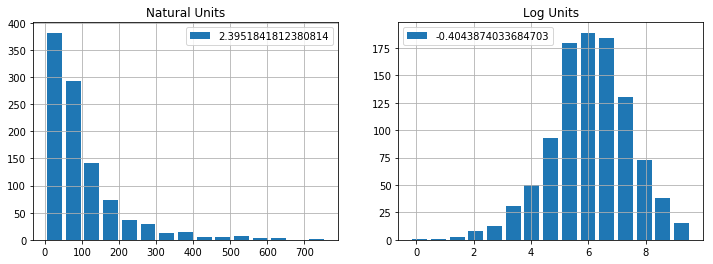

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
param =dict(bins=15, rwidth=.8)
x.hist(**param, ax=ax[0], label=str(skew(x)))
ax[0].set_title('Natural Units')
ax[0].legend()
np.log2(x).hist(**param, ax=ax[1], label=str(skew(np.log2(x))))
ax[1].set_title('Log Units')
ax[1].legend()

estimated lambda: 0.1215319334034963


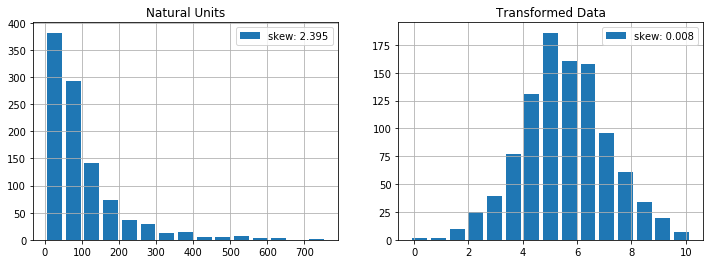

In [18]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))

x_prime, lam = boxcox(x)
x.hist(**param, ax=ax0, label="skew: {:.3f}".format(skew(x)))
ax0.set_title('Natural Units')
ax0.legend()
pd.Series(x_prime).hist(**param, ax=ax1, label="skew: {:.3f}".format(skew(x_prime)))
ax1.set_title('Transformed Data')
ax1.legend()
print("estimated lambda: {}".format(lam))

estimated lambda: -1.09128437890813


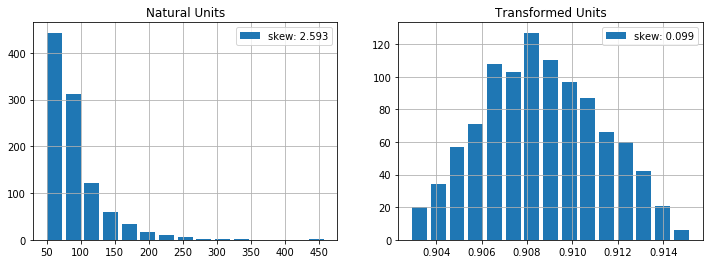

In [19]:
x = train.PerimCh1
x_prime, lam = boxcox(x)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))
x.hist(**param, ax=ax0, label="skew: {:.3f}".format(skew(x)))
ax0.set(title="Natural Units")
ax0.legend()

pd.Series(x_prime).hist(**param, ax=ax1, label="skew: {:.3f}".format(skew(x_prime)))
ax1.set(title="Transformed Units")
ax1.legend()

print("estimated lambda: {}".format(lam))

In [20]:
can_transformed = data.columns[3:][data.iloc[:, 3:].min() > 0]

In [21]:
can_transformed

Index(['AngleCh1', 'AreaCh1', 'AvgIntenCh1', 'AvgIntenCh3', 'AvgIntenCh4',
       'ConvexHullAreaRatioCh1', 'ConvexHullPerimRatioCh1',
       'DiffIntenDensityCh1', 'DiffIntenDensityCh3', 'DiffIntenDensityCh4',
       'EntropyIntenCh1', 'EntropyIntenCh3', 'EntropyIntenCh4',
       'EqCircDiamCh1', 'EqEllipseLWRCh1', 'EqEllipseOblateVolCh1',
       'EqEllipseProlateVolCh1', 'EqSphereAreaCh1', 'EqSphereVolCh1',
       'FiberLengthCh1', 'FiberWidthCh1', 'IntenCoocASMCh3', 'IntenCoocASMCh4',
       'IntenCoocContrastCh3', 'IntenCoocContrastCh4', 'IntenCoocEntropyCh3',
       'IntenCoocEntropyCh4', 'IntenCoocMaxCh3', 'IntenCoocMaxCh4',
       'LengthCh1', 'NeighborAvgDistCh1', 'NeighborMinDistCh1',
       'NeighborVarDistCh1', 'PerimCh1', 'ShapeBFRCh1', 'ShapeLWRCh1',
       'ShapeP2ACh1', 'TotalIntenCh1', 'TotalIntenCh3', 'TotalIntenCh4',
       'VarIntenCh1', 'VarIntenCh3', 'VarIntenCh4', 'WidthCh1', 'XCentroid',
       'YCentroid'],
      dtype='object')

In [4]:
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    '''perform box-cox transformation to resolve skewness'''
    
    def __init__(self):
        self.is_fit = False
        
    def fit(self, X, y=None):
        self.is_fit = False
        return self
    
    def transform(self, X):
        from scipy.stats import boxcox
        if not self.is_fit:
            self.is_fit = True
            X, self.lam_ = boxcox(X)
        else:
            X = boxcox(X, lmbda=self.lam_)
        return X

In [23]:
boxcox_features = gen_features(columns=list(can_transformed), classes=[BoxCoxTransformer])

In [24]:
boxcox_mapper = DataFrameMapper(boxcox_features, input_df=True, df_out=True)

In [25]:
X = boxcox_mapper.fit_transform(train)

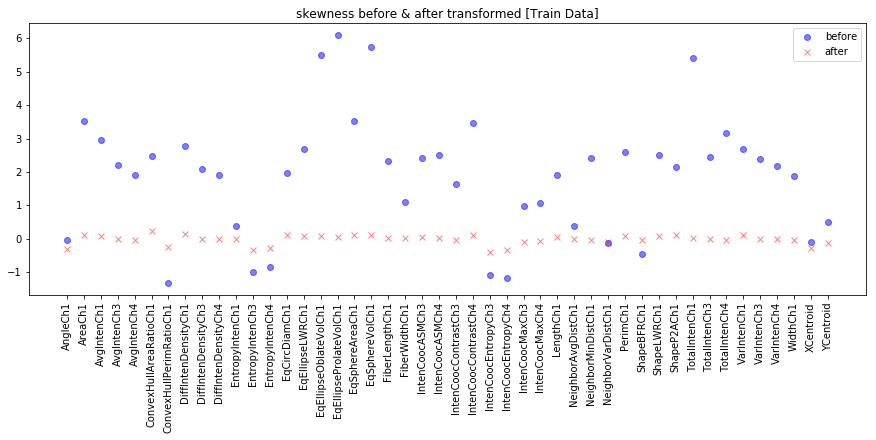

In [26]:
skew_before = [skew(train[c]) for c in can_transformed]
skew_after = [skew(X[c]) for c in can_transformed]
xs = range(1, len(X.columns)+1)

plt.figure(figsize=(15, 5))
plt.plot(xs, skew_before, 'bo', label='before', alpha=.5)
plt.plot(xs, skew_after, 'rx', label='after', alpha=.5)
plt.xticks(xs, list(can_transformed), rotation=90)
plt.legend()
plt.title('skewness before & after transformed [Train Data]')
plt.show()

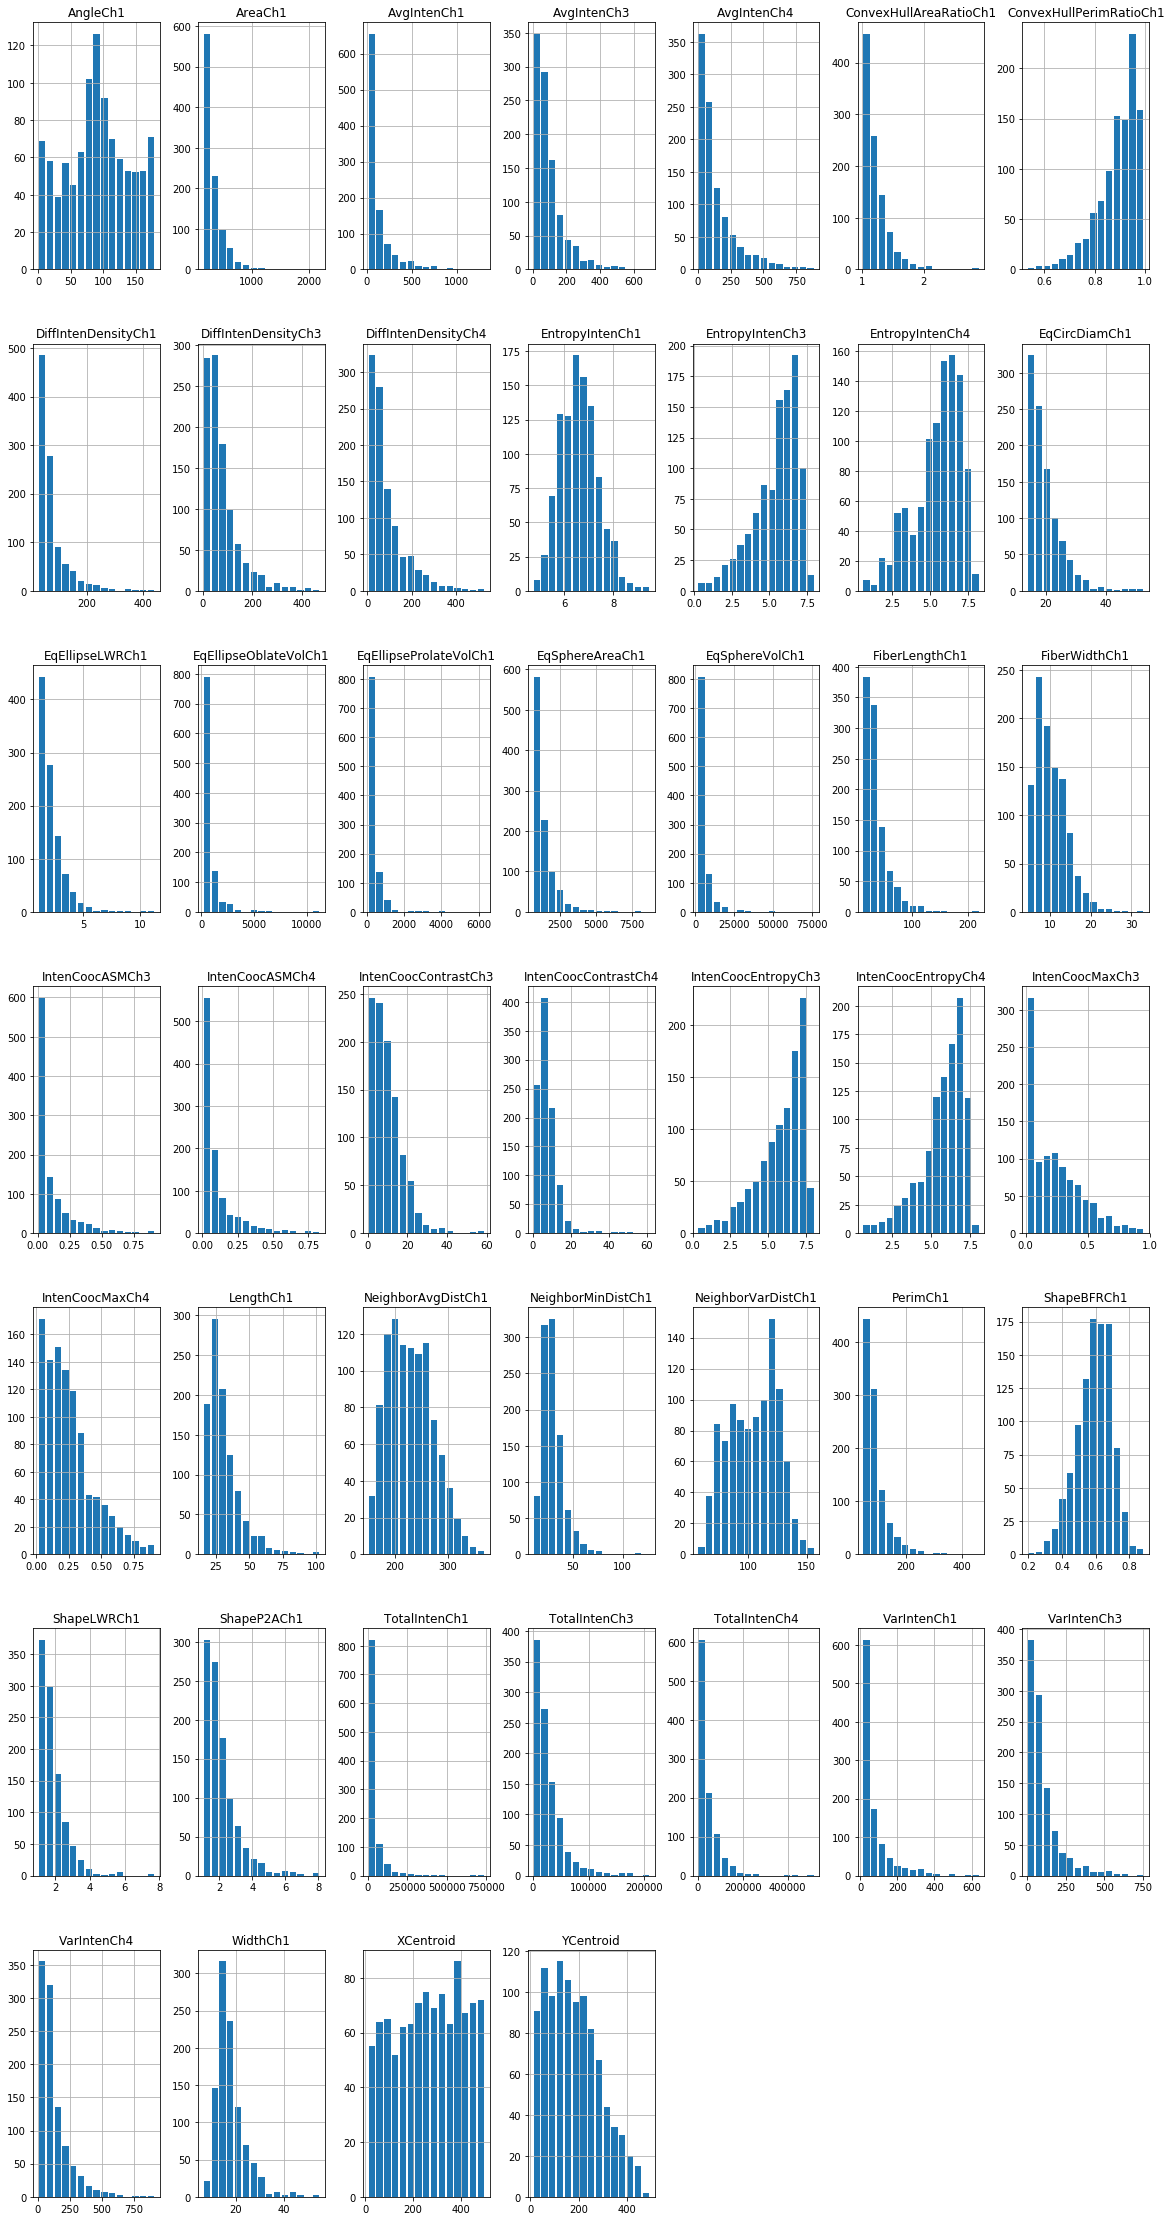

In [27]:
# Before Boxcox
_ = train[can_transformed].hist(**param, figsize=(20, 40))

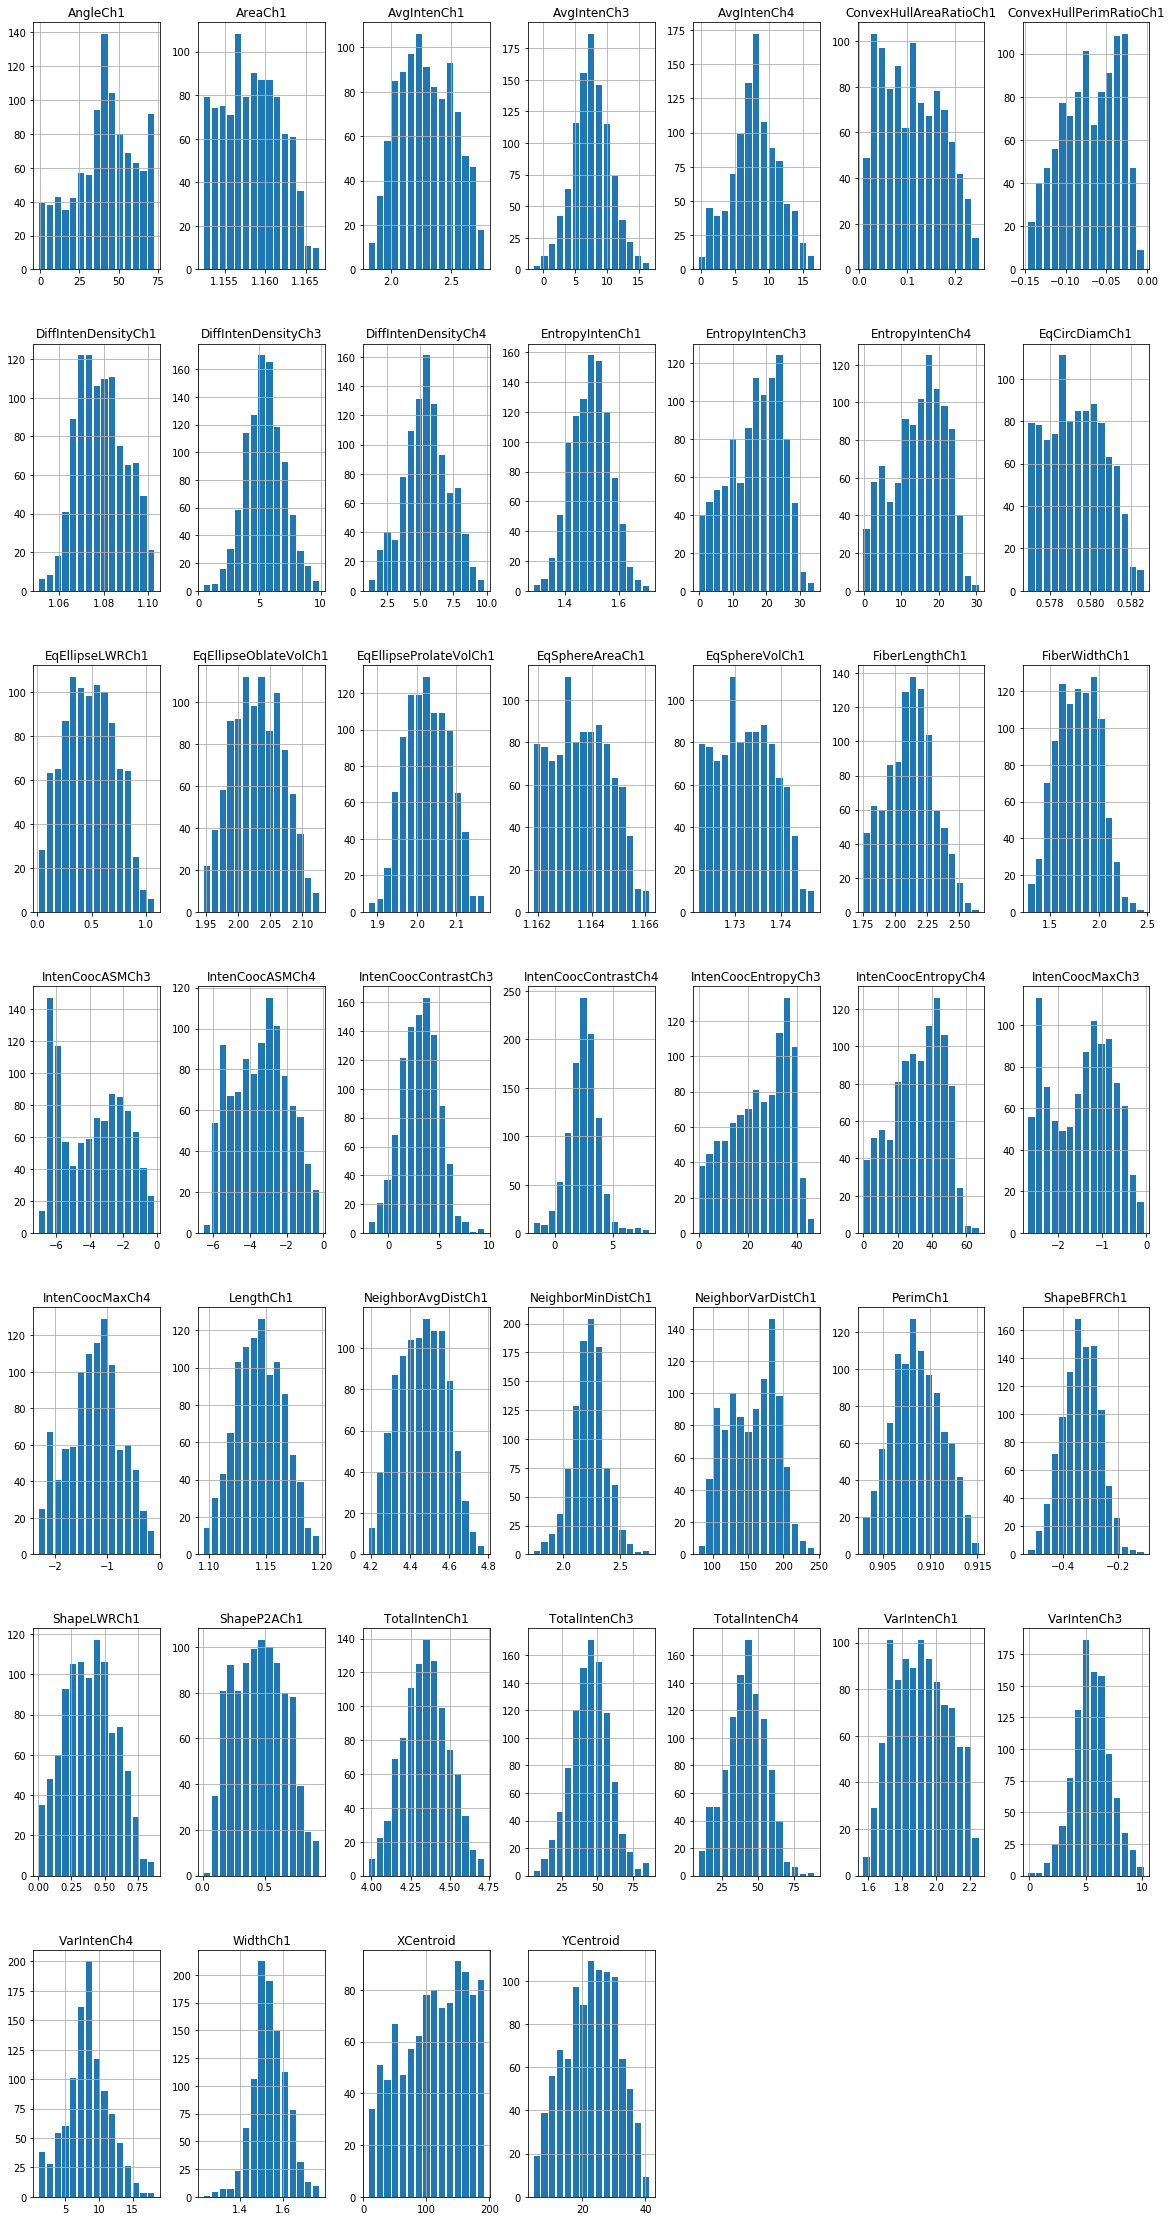

In [28]:
# After Boxcox
_ = X.hist(**param, figsize=(20, 40))

In [29]:
X_train = boxcox_mapper.transform(test)

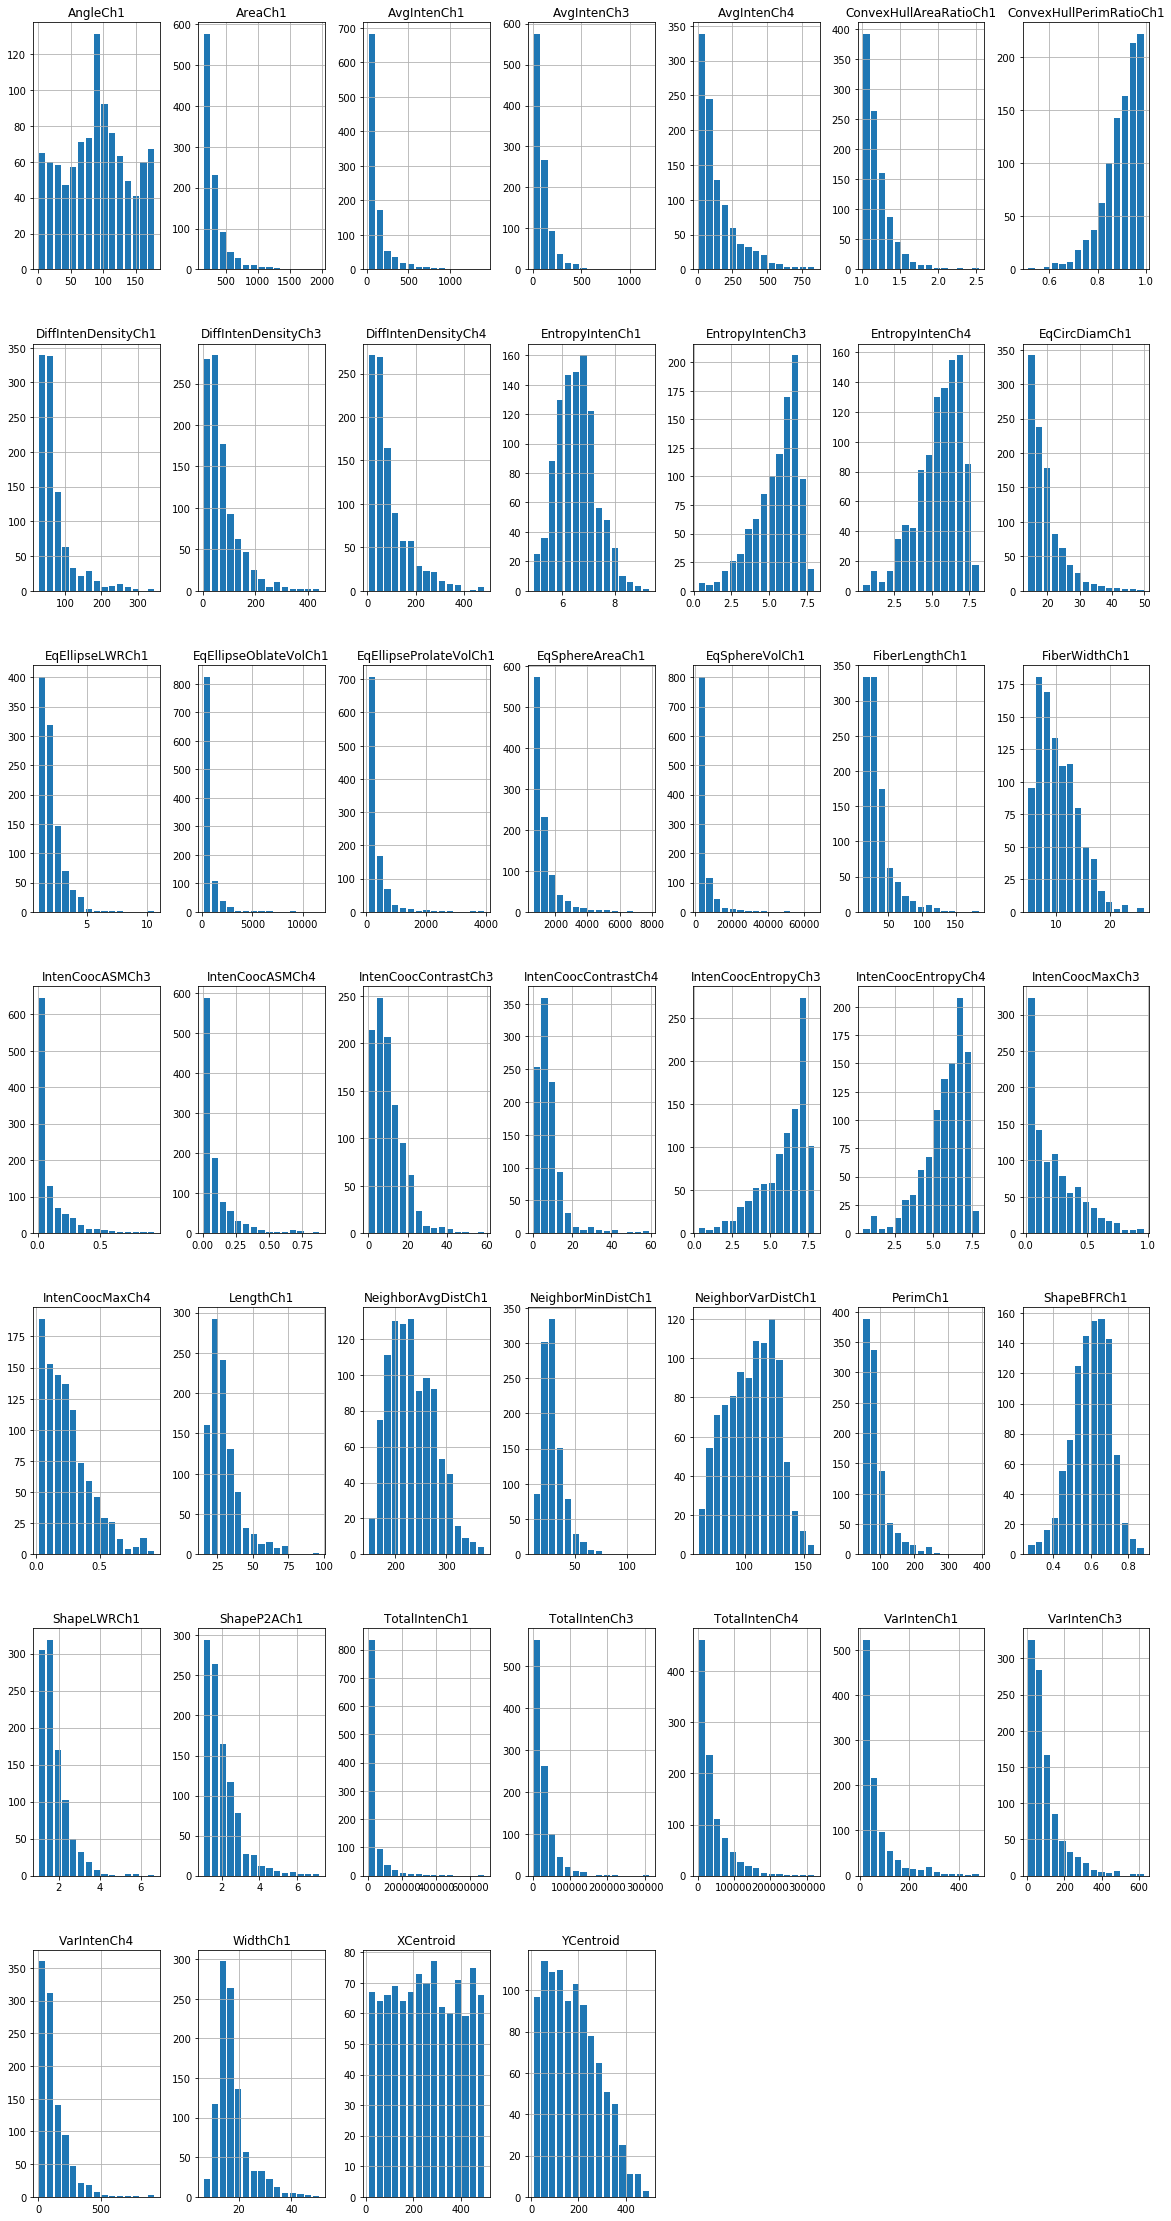

In [30]:
# before Boxcox [test data]
_ = test[can_transformed].hist(**param, figsize=(20, 40))

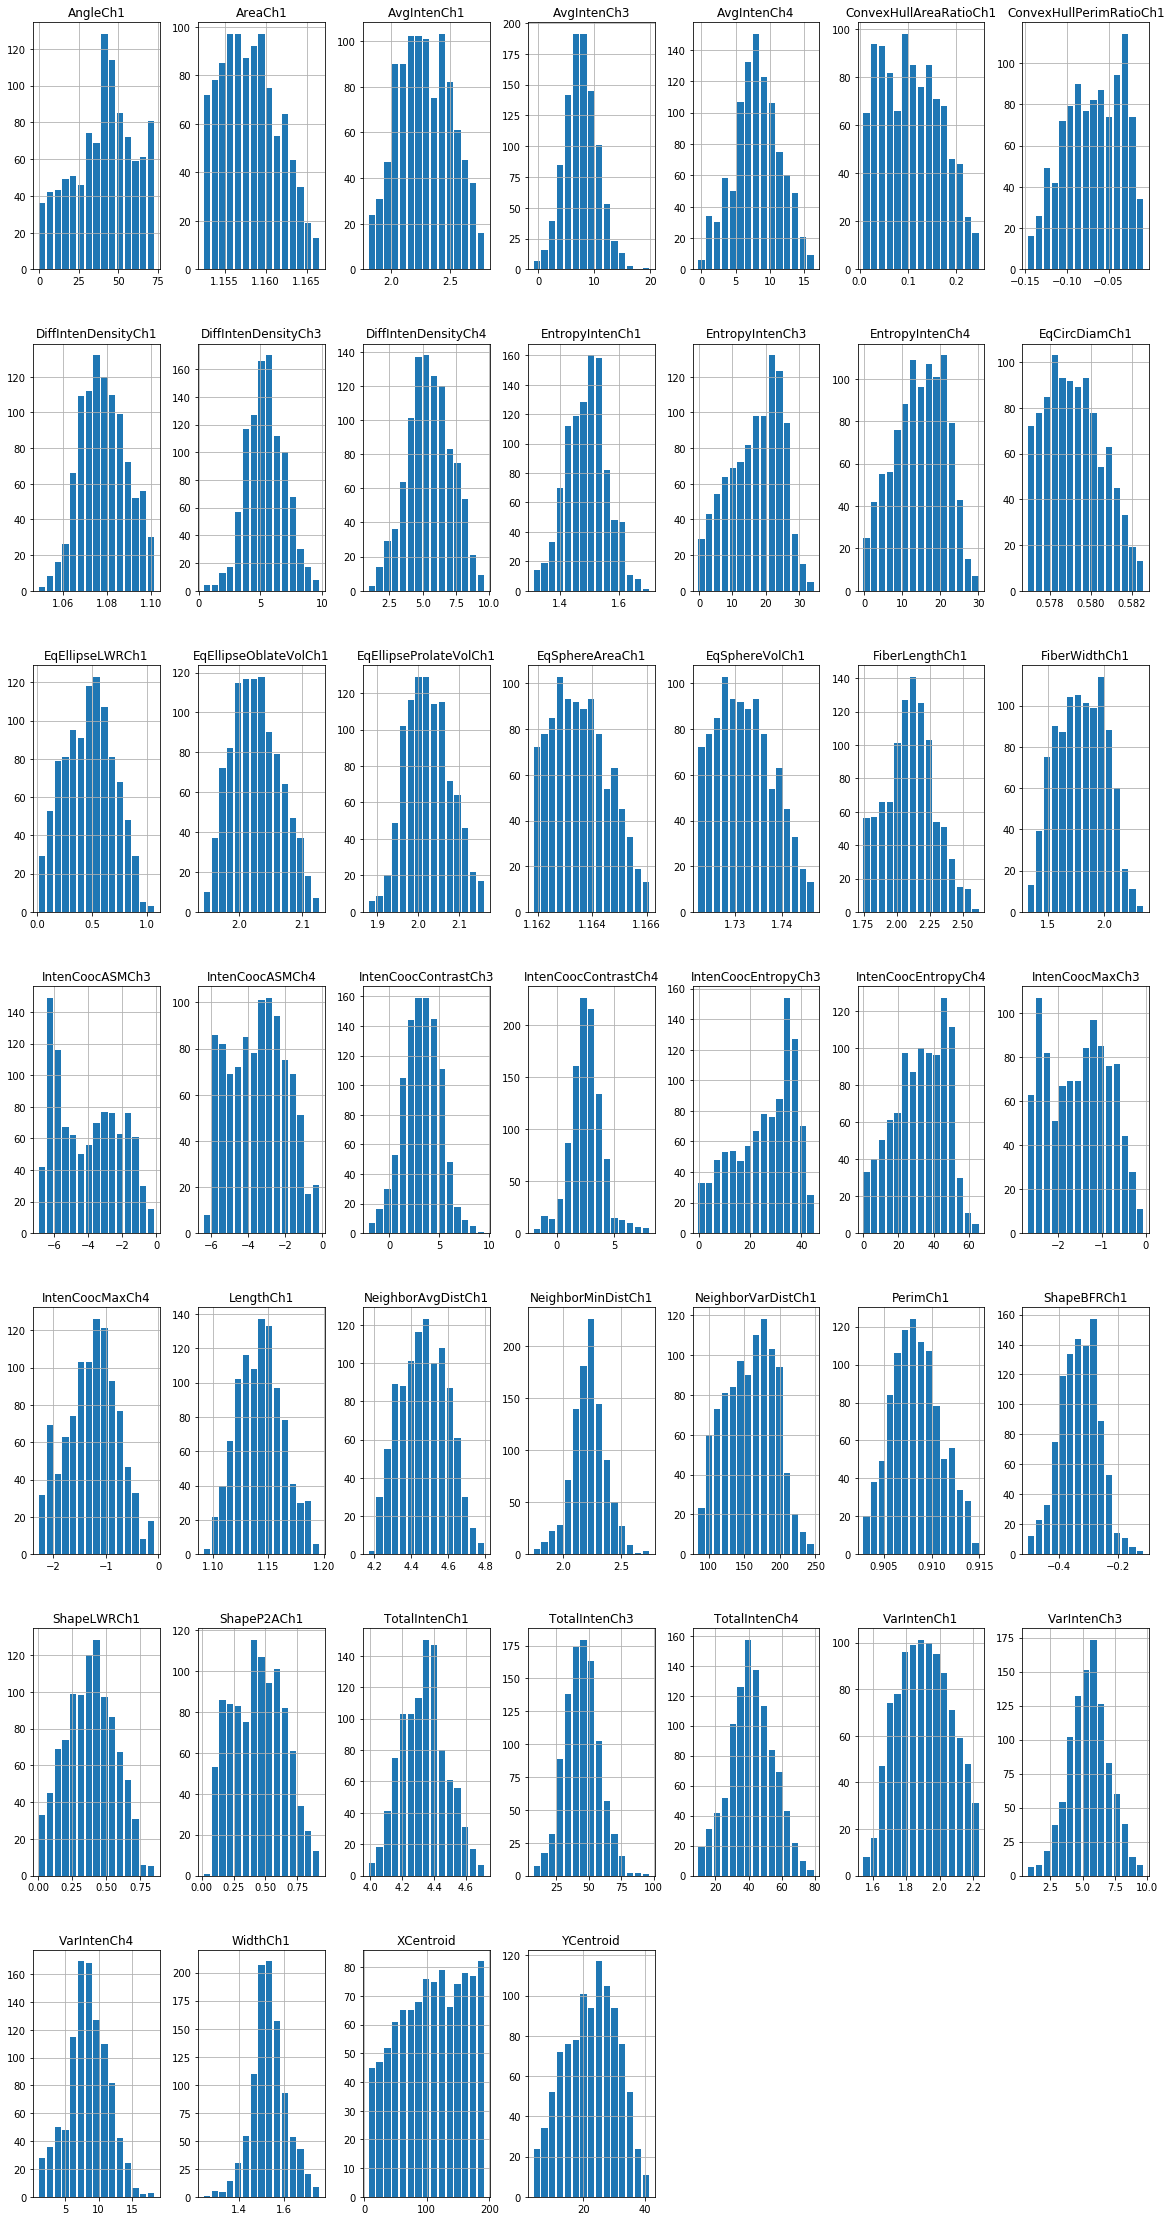

In [31]:
# after Boxcox [test data]
_ = X_train.hist(**param, figsize=(20, 40))

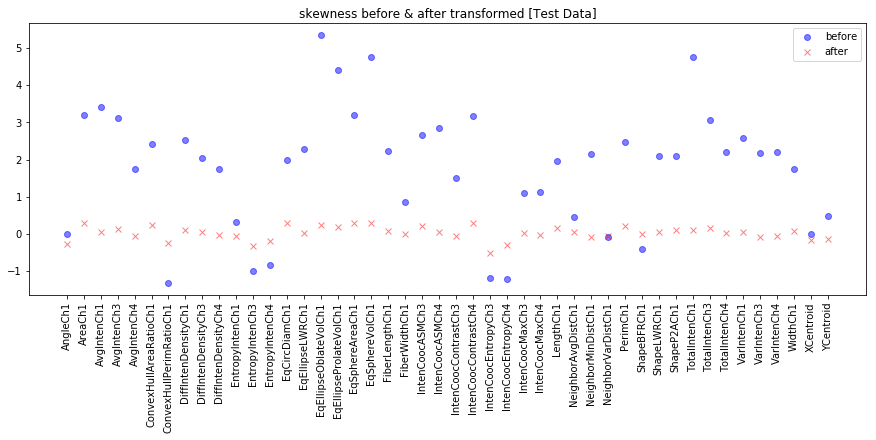

In [32]:
skew_before = [skew(test[c]) for c in can_transformed]
skew_after = [skew(X_train[c]) for c in can_transformed]
xs = range(1, len(X.columns)+1)

plt.figure(figsize=(15, 5))
plt.plot(xs, skew_before, 'bo', label='before', alpha=.5)
plt.plot(xs, skew_after, 'rx', label='after', alpha=.5)
plt.xticks(xs, list(can_transformed), rotation=90)
plt.legend()
plt.title('skewness before & after transformed [Test Data]')
plt.show()

### Data Reduction: PCA

In [33]:
boxcox_mapper = DataFrameMapper(boxcox_features, default=None, input_df=True, df_out=True)

X_boxcox = boxcox_mapper.fit_transform(train.iloc[:, 1:])

Text(0.5,1,'Original Data')

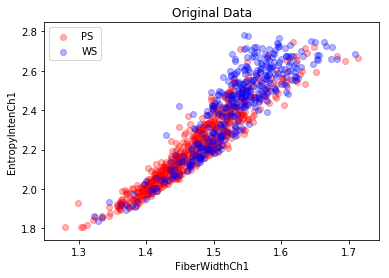

In [34]:
x1 = X_boxcox.EntropyIntenCh1
x2 = X_boxcox.AvgIntenCh1

mask_ps = train.Class == 'PS'

plt.scatter(x1[mask_ps], x2[mask_ps], c='r', alpha=.3, label="PS")
plt.scatter(x1[~mask_ps], x2[~mask_ps], c='b', alpha=.3, label='WS')
plt.legend()
plt.xlabel(train.FiberWidthCh1.name)
plt.ylabel(train.EntropyIntenCh1.name)
plt.title('Original Data')

In [35]:
pca = PCA(n_components=2).fit(scale(np.c_[x1, x2]))

In [36]:
pca.explained_variance_ratio_

array([ 0.96637067,  0.03362933])

In [37]:
x1_new, x2_new = pca.transform(scale(np.c_[x1, x2])).T

[-3, 3, -3, 3]

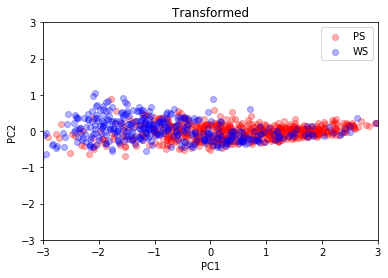

In [38]:
plt.scatter(x1_new[mask_ps], x2_new[mask_ps], c='r', alpha=.3, label='PS')
plt.scatter(x1_new[~mask_ps], x2_new[~mask_ps], c='b', alpha=.3, label='WS')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Transformed")
plt.axis([-3, 3, -3, 3])

In [39]:
sc = StandardScaler()
pca = PCA()
X_pca = pca.fit_transform(sc.fit_transform(X_boxcox))

In [258]:
X_pca[:6, :4]

array([[  4.72456344,  10.04434711,   0.19707698,  -0.94235637],
       [ -0.49618482,   1.57369805,  -1.74269542,  -3.89566479],
       [  3.57914998,  -0.70426625,  -1.52836025,  -1.03805168],
       [ -0.4475648 ,  -1.77947459,   0.940512  ,  -4.16325053],
       [  0.51509153,  -0.78387134,  -1.45034288,  -4.68025816],
       [ -0.78500564,   0.4890406 ,  -0.34274672,  -3.35038859]])

Text(0.5,1,'Scree Plot')

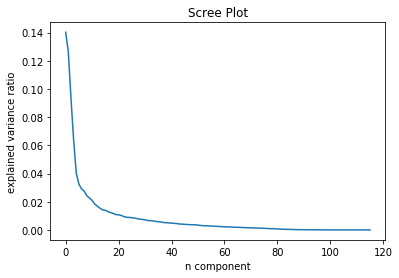

In [40]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('n component')
plt.ylabel('explained variance ratio')
plt.title('Scree Plot')

In [41]:
(pca.explained_variance_ratio_.cumsum() < .99).sum()

74

In [42]:
pca.explained_variance_ratio_.round(3)

array([ 0.14 ,  0.126,  0.094,  0.064,  0.04 ,  0.032,  0.029,  0.027,
        0.024,  0.023,  0.021,  0.018,  0.017,  0.015,  0.014,  0.014,
        0.013,  0.012,  0.012,  0.011,  0.011,  0.01 ,  0.009,  0.009,
        0.009,  0.009,  0.008,  0.008,  0.008,  0.007,  0.007,  0.007,
        0.007,  0.006,  0.006,  0.006,  0.006,  0.005,  0.005,  0.005,
        0.005,  0.005,  0.005,  0.004,  0.004,  0.004,  0.004,  0.004,
        0.004,  0.004,  0.003,  0.003,  0.003,  0.003,  0.003,  0.003,
        0.003,  0.003,  0.002,  0.002,  0.002,  0.002,  0.002,  0.002,
        0.002,  0.002,  0.002,  0.002,  0.002,  0.002,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
      

In [43]:
len(pca.explained_variance_)

116

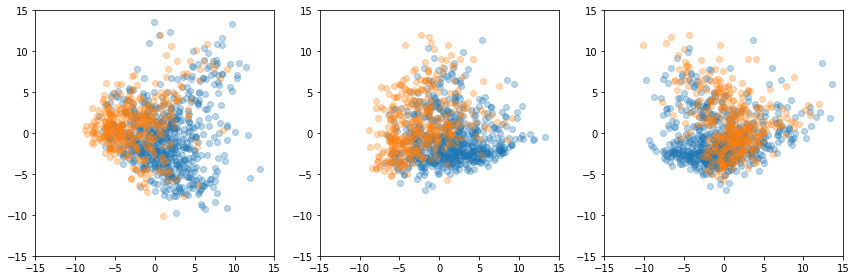

In [44]:
a, b, c = X_pca[:, :3].T
xy = [-15, 15, -15, 15]
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
for axi, (c1, c2) in zip(ax.flat, [(a,b),(a,c), (b,c)]):
    axi.scatter(c1[mask_ps], c2[mask_ps], alpha=.3)
    axi.scatter(c1[~mask_ps], c2[~mask_ps], alpha=.3)
    axi.axis(xy)
fig.tight_layout()

In [45]:
# (n_component, n_features)
pca.components_.shape

(116, 116)

In [46]:
pca.components_[0]

array([ 0.00550145,  0.08441695, -0.18067485, -0.06331412, -0.16500705,
        0.19359603, -0.18093174, -0.16564625, -0.05528059, -0.16047089,
       -0.1399163 ,  0.04599415, -0.13632336,  0.0844055 ,  0.14050793,
        0.12376496,  0.03765552,  0.08440551,  0.0844055 ,  0.19812402,
       -0.14796797, -0.0809514 ,  0.11822511,  0.10493006, -0.06427903,
        0.08742971, -0.11213545, -0.07975926,  0.12184507,  0.1708526 ,
        0.01694843,  0.05023485,  0.01129772,  0.17544866, -0.1579565 ,
        0.12409439,  0.20791778, -0.12082028, -0.01382022, -0.11357547,
       -0.16360669, -0.08723571, -0.14726279,  0.04672434,  0.01724639,
        0.00385136, -0.01863852,  0.08966379, -0.18306264, -0.1399128 ,
        0.0752365 , -0.06364277, -0.01274673,  0.08321994,  0.04730356,
       -0.10466243, -0.01396273,  0.03462918,  0.02111361, -0.0252939 ,
        0.05495066,  0.04443286,  0.05454211,  0.10164131,  0.07720722,
        0.08966379,  0.09191734,  0.03083019,  0.00064775,  0.01

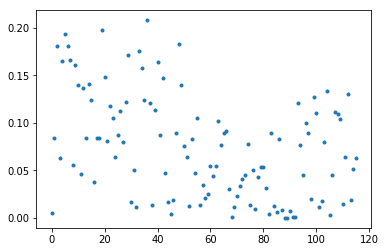

In [47]:
plt.plot(np.abs(pca.components_[0]), '.')

In [48]:
ch1 = X_boxcox.columns.str.endswith('Ch1')
ch3 = X_boxcox.columns.str.endswith('Ch3')
ch4 = X_boxcox.columns.str.endswith('Ch4')
ch2 = X_boxcox.columns.str.endswith('Ch2')

In [49]:
ch1.sum(), ch2.sum(), ch3.sum(), ch4.sum()

(56, 6, 26, 26)

In [50]:
pc123 = pd.DataFrame(pca.components_[:3].T, columns=['pc1', 'pc2', 'pc3'])

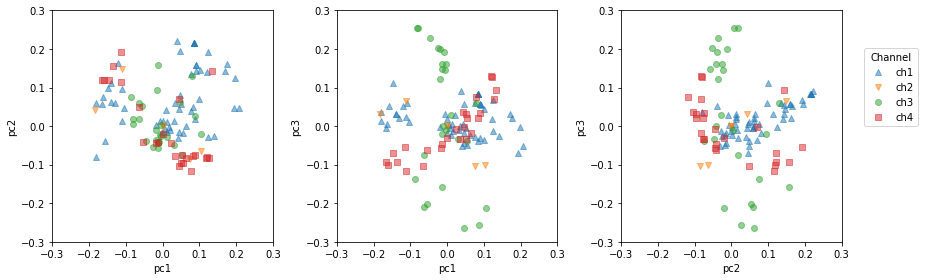

In [52]:
xy = [-.3, .3, -.3, .3]
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
for (c1, c2), axi in zip([(a, b) for i, a in enumerate(pc123.columns) for b in pc123.columns[i+1:]], ax.flat):
    a, b = pc123[c1], pc123[c2]
    axi.scatter(a[ch1], b[ch1], marker='^', label='ch1', alpha=.5)
    axi.scatter(a[ch2], b[ch2], marker='v', label='ch2', alpha=.5)
    axi.scatter(a[ch3], b[ch3], marker='o', label='ch3', alpha=.5)
    axi.scatter(a[ch4], b[ch4], marker='s', label='ch4', alpha=.5)
    axi.axis(xy)
    axi.set(xlabel=c1, ylabel=c2)
axi.legend(loc=[1.1, .5], title='Channel')
fig.tight_layout()


### Dealing with Missing Values

In [64]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

### Using K-nearest neighbor model

In [111]:
y_train = train.PerimCh1.values
X_train = train.drop(['Class', 'PerimCh1'], axis=1).values

y_test_all = test.PerimCh1.values
X_test_all = test.drop(['Class', 'PerimCh1'], axis=1).values

nan_idx = np.random.permutation(range(len(X_test)))[:50]
y_test_nan = y_test_all[nan_idx]
X_test_nan = X_test_all[nan_idx, :]

X_train.shape, X_test_all.shape, X_test_nan.shape

((1009, 115), (1010, 115), (50, 115))

In [112]:
scx = StandardScaler()
scy = StandardScaler()
knn = KNeighborsRegressor(n_neighbors=5, weights='distance').fit(sc.fit_transform(X_train), 
                                                                 scy.fit_transform(y_train[:, None]))
y_test_pred = knn.predict(sc.transform(X_test_nan))

Text(0,0.5,'imputed')

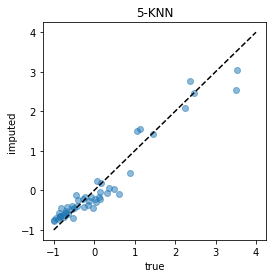

In [113]:
plt.figure(figsize=(4, 4))
plt.scatter(scy.transform(y_test_nan[:,None]).ravel(), y_test_pred, alpha=.5)
plt.plot([-1, 4], [-1, 4], '--k')
plt.title('5-KNN')
plt.xlabel('true')
plt.ylabel('imputed')

In [115]:
np.corrcoef(scy.transform(y_test_nan[:, None]).ravel(), y_test_pred.ravel())

array([[ 1.        ,  0.96378351],
       [ 0.96378351,  1.        ]])

In [117]:
pearsonr(scy.transform(y_test_nan[:, None]).ravel(), y_test_pred.ravel())

(0.96378351083050928, 3.3297718840196796e-29)

### Using Linear Regression model

In [118]:
corr = train.corr()

a = corr.loc['PerimCh1'].apply(np.abs)
a.sort_values(ascending=False)[:5]

PerimCh1           1.000000
FiberLengthCh1     0.985296
LengthCh1          0.921818
EqCircDiamCh1      0.856851
EqSphereAreaCh1    0.848077
Name: PerimCh1, dtype: float64

In [119]:
X_train = train[['FiberLengthCh1']].values
X_test = test[['FiberLengthCh1']].values
X_test = X_test[nan_idx, :]

X_train.shape, X_test.shape

((1009, 1), (50, 1))

In [120]:
linreg = LinearRegression()
linreg.fit(scx.fit_transform(X_train), scy.fit_transform(y_train[:, None]))
y_pred = linreg.predict(scx.transform(X_test))

Text(0,0.5,'imputed')

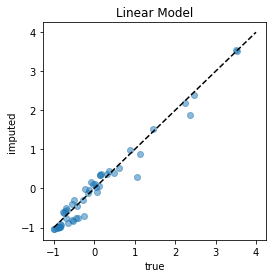

In [121]:
plt.figure(figsize=(4, 4))
plt.scatter(scy.transform(y_test_nan[:, None]).ravel(), y_pred, alpha=.5)
plt.plot([-1, 4], [-1, 4], '--k')
plt.title('Linear Model')
plt.xlabel('true')
plt.ylabel('imputed')

In [122]:
np.corrcoef(scy.transform(y_test_nan[:, None]).ravel(), y_pred.ravel())

array([[ 1.        ,  0.98336823],
       [ 0.98336823,  1.        ]])

In [123]:
pearsonr(scy.transform(y_test_nan[:, None]).ravel(), y_pred.ravel())

(0.98336822885015995, 3.2081165097690418e-37)

## Removing Predictors

In [155]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [186]:
corr = train.drop(['Class', 'MemberAvgAvgIntenStatusCh2', 'MemberAvgTotalIntenStatusCh2'], axis=1).corr()
#MemberAvgAvgIntenStatusCh2      
#MemberAvgTotalIntenStatusCh2    

In [221]:
Y = linkage(corr.values, method='complete', metric='correlation')
Z = dendrogram(Y, color_threshold=0, no_plot=True)['leaves']
corr = corr.iloc[:, Z]
corr = corr.iloc[Z, :]

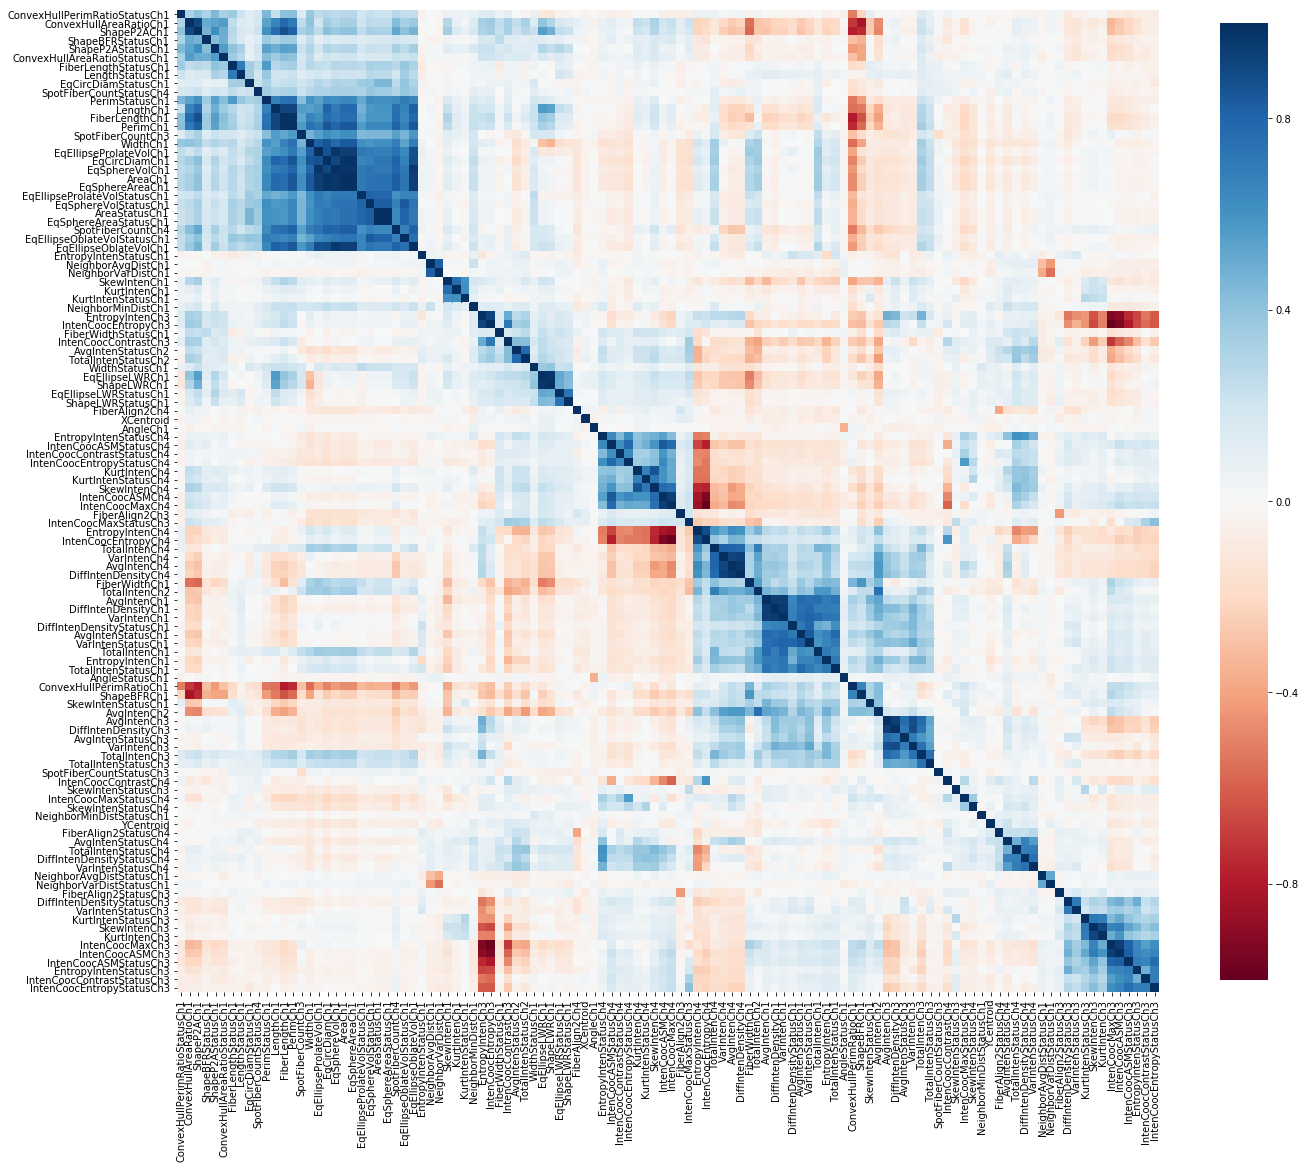

In [222]:
fig, ax = plt.subplots(figsize=(22, 22))
sns.heatmap(corr, square=True, ax=ax, vmin=-1, vmax=1, cmap=plt.cm.RdBu, 
            cbar_kws={'shrink':.8}, yticklabels=True, xticklabels=True)

#### redundant predictors: heuristic approach

In [200]:
threshold = .75
to_remove = set()
for i, c1 in enumerate(corr.columns):
    for c2 in corr.columns[i+1:]:
        val = corr.loc[c1, c2]
        if val > threshold:
            if corr[c1].sum() > corr[c2].sum():
                to_remove.add(c1)
            else:
                to_remove.add(c2)
print(len(to_remove))

43


In [262]:
valid_boxcox = train_num.columns[train_num.min() > 0]
valid_boxcox.shape

(47,)

In [264]:
boxcox_transform = DataFrameMapper(features=gen_features(list(valid_boxcox), classes=[BoxCoxTransformer]), 
                                    default=None, df_out=True, input_df=True)

In [265]:
X_num_boxcox = boxcox_transform.fit_transform(train_num)

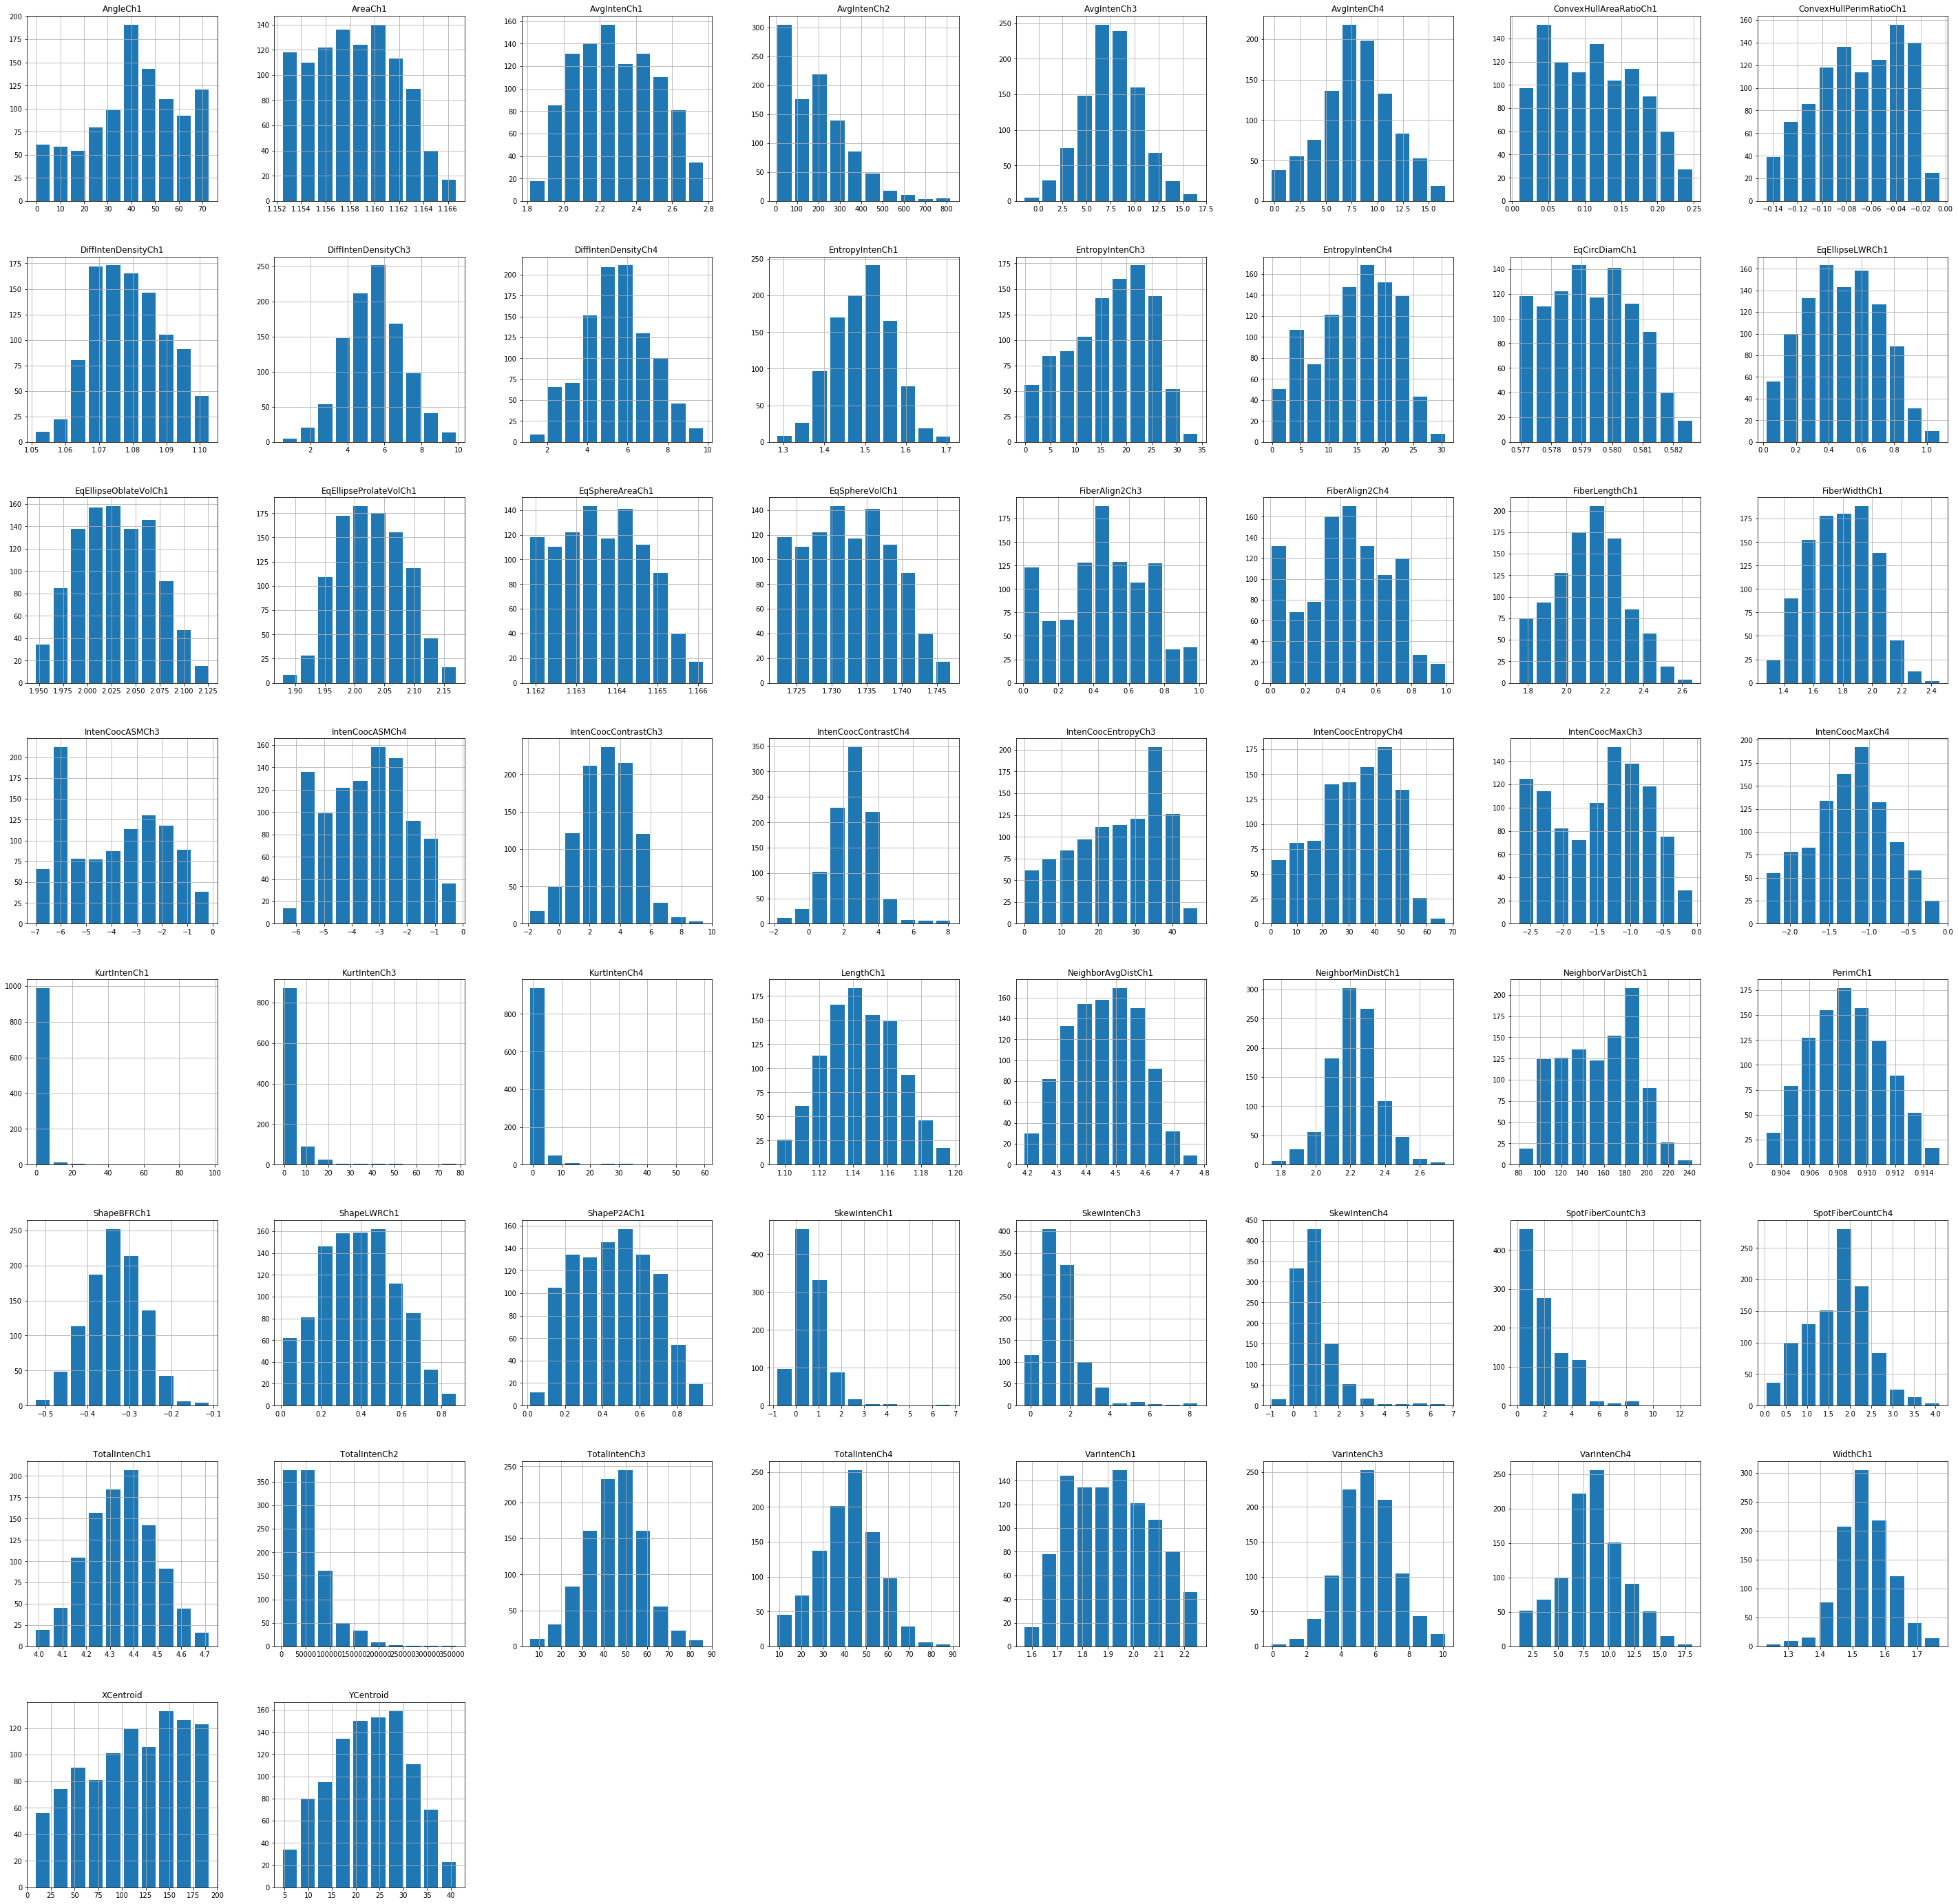

In [267]:
_ = X_num_boxcox.hist(rwidth=.8, figsize=(50, 50))

In [270]:
sc = StandardScaler()
pca = PCA()

X_boxcox_pca = pca.fit_transform(sc.fit_transform(X_num_boxcox))

In [271]:
pca.explained_variance_ratio_.round(3)

array([ 0.221,  0.187,  0.134,  0.078,  0.048,  0.038,  0.035,  0.032,
        0.023,  0.022,  0.02 ,  0.019,  0.017,  0.016,  0.015,  0.014,
        0.013,  0.012,  0.011,  0.009,  0.006,  0.005,  0.004,  0.003,
        0.002,  0.002,  0.002,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ])

In [278]:
# 18 components to capture 95% of the variance
(pca.explained_variance_ratio_.cumsum() < .95).sum()

18

In [273]:
X_boxcox_pca[:6, :5]

array([[ 1.66098663,  6.33785768, -0.35675819, -3.1434496 , -1.26674415],
       [-0.63221435,  2.02630573, -1.49343839, -4.81148491, -1.63950289],
       [ 3.85641642, -0.4430067 , -0.66617731, -4.02131729,  1.85733751],
       [ 0.43028411, -2.24420802,  1.46033444, -5.36856924, -0.23222835],
       [ 1.11985558, -1.5483867 , -0.99128758, -5.69059141, -0.76891347],
       [-0.41571105,  0.18099805,  0.52765106, -2.08306216, -1.9695963 ]])

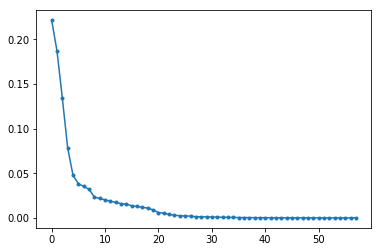

In [275]:
plt.plot(pca.explained_variance_ratio_, '.-')

In [279]:
pc1, pc2, pc3 = X_boxcox_pca[:, :3].T

In [283]:
def plot_pca(pc1, pc2):
    plt.figure(figsize=(4,4))
    xy = [-10, 15, -10, 15]
    plt.scatter(pc1[mask_ps], pc2[mask_ps], alpha=.3)
    plt.scatter(pc1[~mask_ps], pc2[~mask_ps], alpha=.3)
    plt.axis(xy)

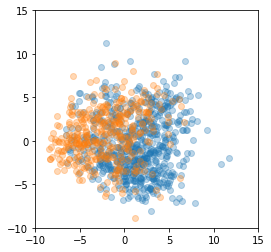

In [284]:
plot_pca(pc1, pc2)

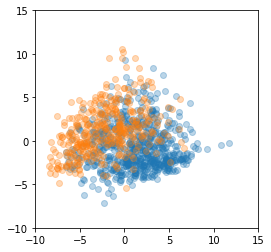

In [285]:

plot_pca(pc1, pc3)

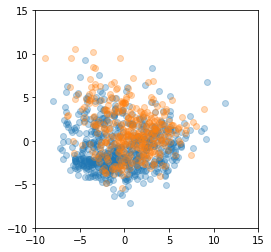

In [286]:
plot_pca(pc2, pc3)

## Exercises

### 3.1 glass identification


In [222]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"

cols = "RI Na Mg Al Si K Ca Ba Fe Type".split()
glass = pd.read_csv(url, header=None, index_col=0, names=cols)

In [294]:
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [295]:
glass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
RI      214 non-null float64
Na      214 non-null float64
Mg      214 non-null float64
Al      214 non-null float64
Si      214 non-null float64
K       214 non-null float64
Ca      214 non-null float64
Ba      214 non-null float64
Fe      214 non-null float64
Type    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [296]:
glass.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [227]:
y = glass['Type']
X = glass.drop('Type', axis=1)

X.shape, y.shape

((214, 9), (214,))

In [228]:
skewness = pd.Series(skew(X), index=X.columns)
skewness

RI    1.614015
Na    0.450992
Mg   -1.144465
Al    0.900918
Si   -0.725317
K     6.505636
Ca    2.032677
Ba    3.392431
Fe    1.742007
dtype: float64

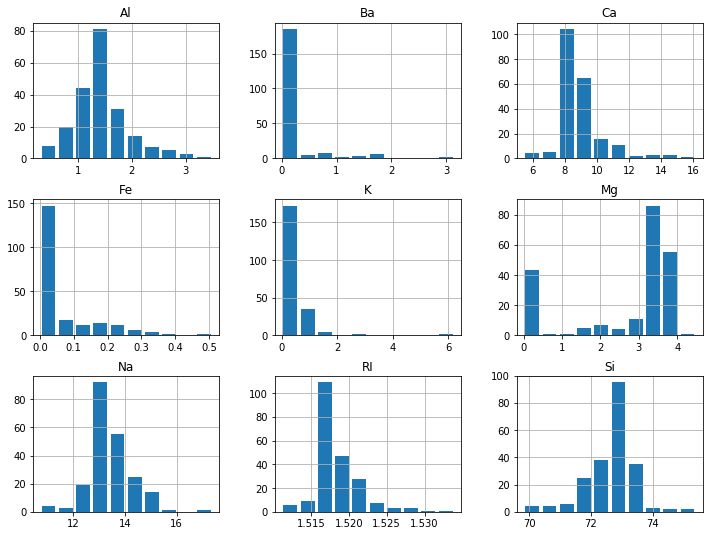

In [302]:
_ = X.hist(figsize=(12, 9), rwidth=.8)

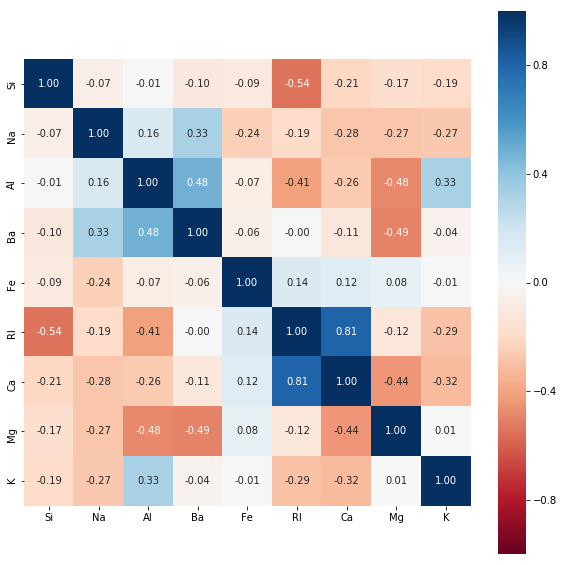

In [309]:
corr = X.corr()

Y = linkage(corr.values, method='complete', metric='correlation')
Z = dendrogram(Y, no_plot=True)['leaves']

corr = corr.iloc[:, Z]
corr = corr.iloc[Z, :]
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, square=True, annot=True, ax=ax, fmt='.2f', vmin=-1, vmax=1, cmap=plt.cm.RdBu)

In [229]:
valid_boxcox = X.columns[X.min() > 0]
valid_boxcox

Index(['RI', 'Na', 'Al', 'Si', 'Ca'], dtype='object')

In [230]:
skew(X[valid_boxcox])

array([ 1.61401505,  0.45099172,  0.90091788, -0.72531727,  2.03267738])

In [313]:
glass_boxcox = DataFrameMapper(features=gen_features(list(valid_boxcox), classes=[BoxCoxTransformer]), 
                               default=None, input_df=True, df_out=True)
X_boxcox = glass_boxcox.fit_transform(X)

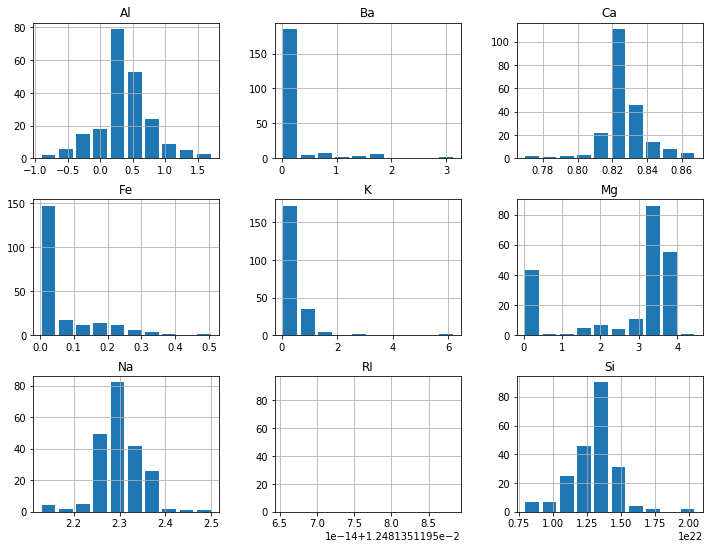

In [314]:
_ = X_boxcox.hist(figsize=(12, 9), rwidth=.8)

In [317]:
sc = StandardScaler()
pca = PCA()

X_pca = pca.fit_transform(sc.fit_transform(X_boxcox))

In [318]:
pca.explained_variance_ratio_.round(3)

array([ 0.281,  0.212,  0.153,  0.133,  0.1  ,  0.061,  0.048,  0.01 ,
        0.003])

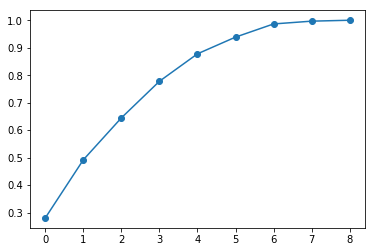

In [320]:
plt.plot(pca.explained_variance_ratio_.cumsum(), 'o-')

In [322]:
y.value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

### 3.2: Soybean

In [6]:
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/soybean/soybean-large.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/soybean/soybean-large.test"

col_names = '''Class date plant_strand precip temp hail crop_hist area_damaged severity seed_tmt germination plant_growth leaves leafspots_halo leafspots_marg leafspot_size leaf_shread leaf_malf leaf_mild stem lodging stem_cankers canker_lesion fruiting_bodies external_decay mycelium int_discolor sclerotia fruit_pods fruit_spots seed modl_growth seed_discolor seed_size shriveling roots'''.split()


In [8]:
#soybean1 = pd.read_csv(train_url, header=None, na_values='?')
#soybens2 = pd.read_csv(test_url, header=None, na_values='?')

soybean = pd.concat([pd.read_csv(train_url, header=None, na_values='?'), 
                     pd.read_csv(test_url, header=None, na_values='?')])
soybean.columns = col_names
soybean.shape

(683, 36)

In [9]:
soybean.head()

,Class,date,plant_strand,precip,temp,hail,crop_hist,area_damaged,severity,seed_tmt,...,int_discolor,sclerotia,fruit_pods,fruit_spots,seed,modl_growth,seed_discolor,seed_size,shriveling,roots
0,diaporthe-stem-canker,6.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,diaporthe-stem-canker,4.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0,1.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,diaporthe-stem-canker,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
3,diaporthe-stem-canker,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,diaporthe-stem-canker,6.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
soybean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 375
Data columns (total 36 columns):
Class              683 non-null object
date               682 non-null float64
plant_strand       647 non-null float64
precip             645 non-null float64
temp               653 non-null float64
hail               562 non-null float64
crop_hist          667 non-null float64
area_damaged       682 non-null float64
severity           562 non-null float64
seed_tmt           562 non-null float64
germination        571 non-null float64
plant_growth       667 non-null float64
leaves             683 non-null int64
leafspots_halo     599 non-null float64
leafspots_marg     599 non-null float64
leafspot_size      599 non-null float64
leaf_shread        583 non-null float64
leaf_malf          599 non-null float64
leaf_mild          575 non-null float64
stem               667 non-null float64
lodging            562 non-null float64
stem_cankers       645 non-null float64
canker_lesion     

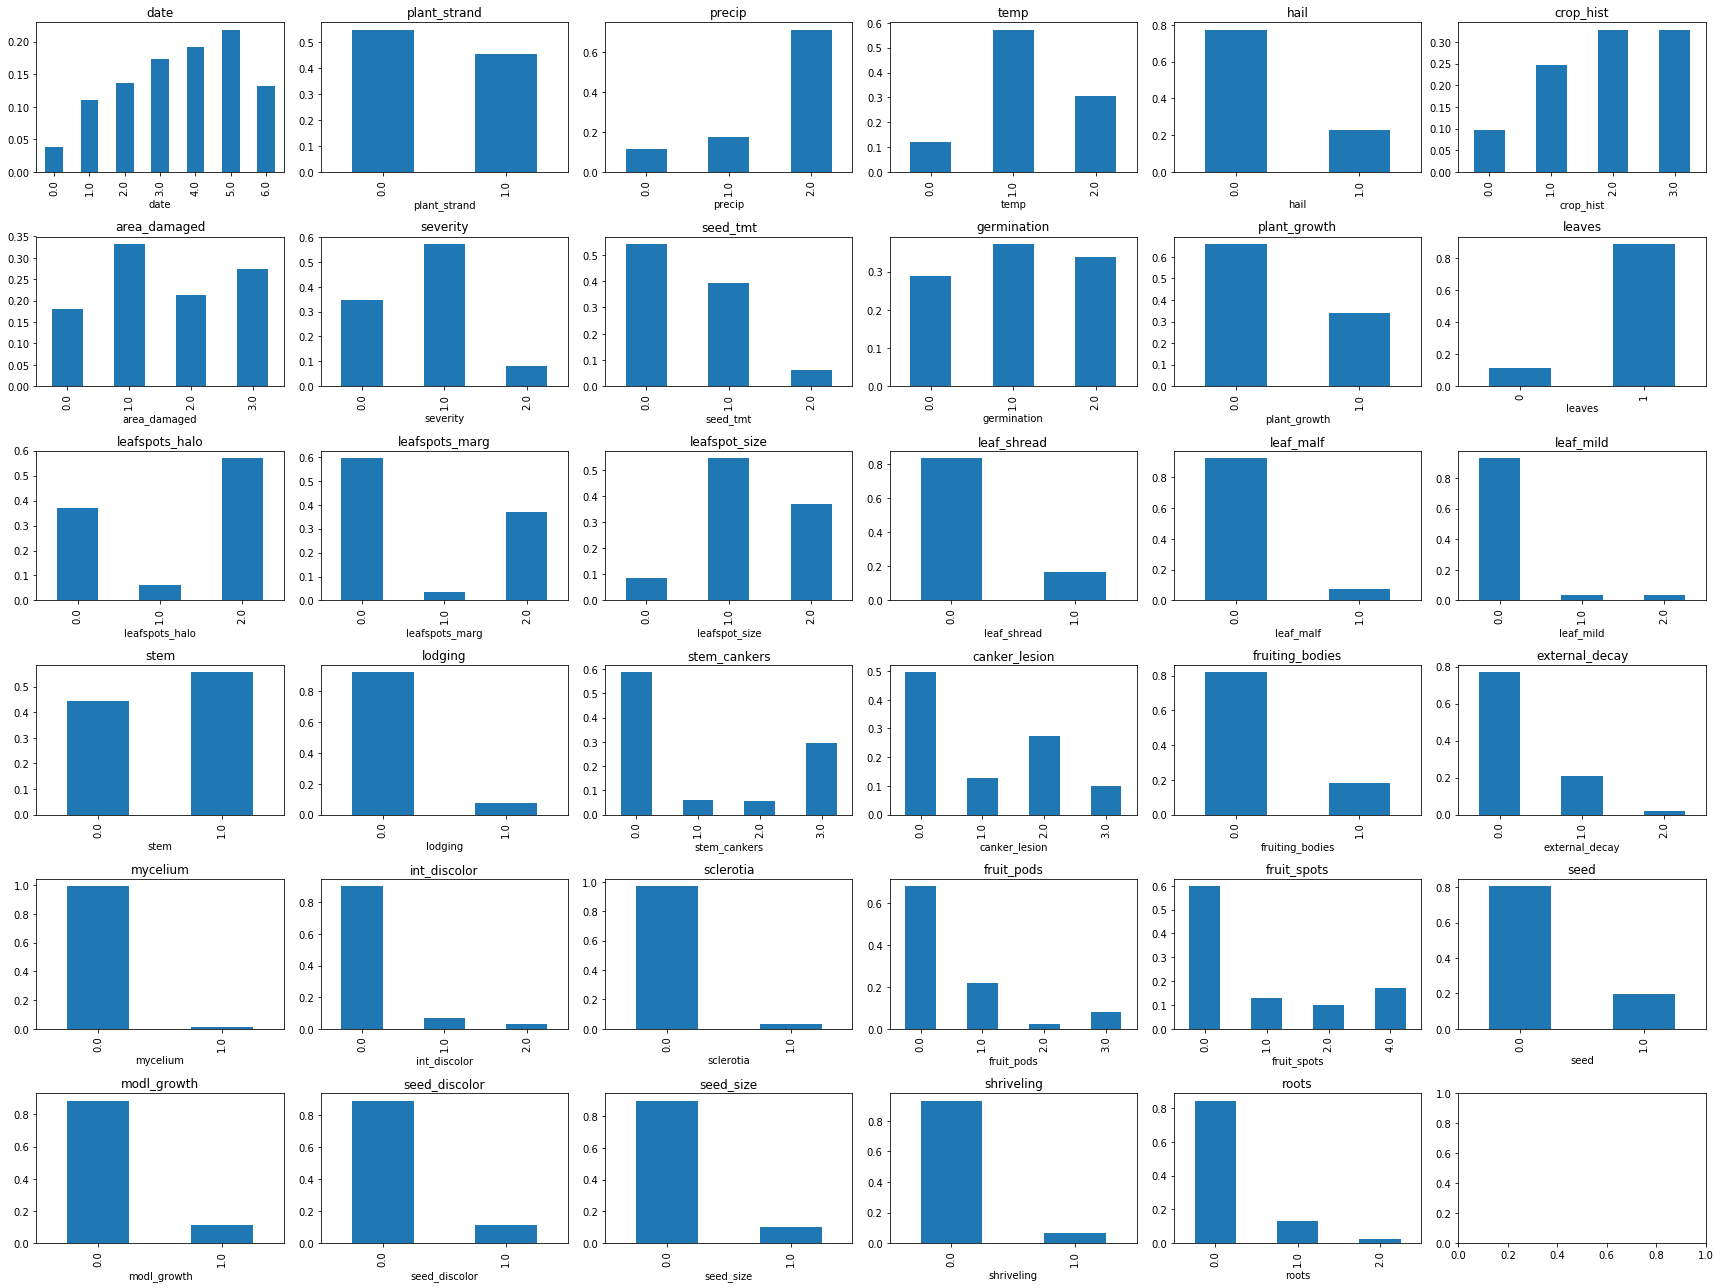

In [32]:
fig, ax = plt.subplots(ncols=6, nrows=6, figsize=(24, 18))
for c, axi in zip(soybean.columns[1:], ax.flat):
    a = soybean.groupby(c)['Class'].count()
    (a / a.sum()).plot.bar(ax=axi, title=c)
fig.tight_layout()

In [33]:
df = pd.DataFrame([soybean[c].nunique() for c in soybean.columns], index=soybean.columns, columns=['unique'])
df['Total'] = soybean.notnull().sum()
df['unique_ratio'] = df['unique'] / df['Total'] * 100

In [44]:
ratio = []
for c in soybean.columns:
    a = soybean.groupby(c)['Class'].count().sort_values(ascending=False)
    ratio.append(a.iloc[0] / a.iloc[1])

In [46]:
df['ratio_freq_most_vs_second'] = ratio

In [49]:
# distrubution degenerate
df.index[df['ratio_freq_most_vs_second'] > 20]

Index(['leaf_mild', 'mycelium', 'sclerotia'], dtype='object')

In [50]:
df

,unique,Total,unique_ratio,ratio_freq_most_vs_second
Class,19,683,2.781845,1.010989
date,7,682,1.026393,1.137405
plant_strand,2,647,0.309119,1.208191
precip,3,645,0.465116,4.098214
temp,3,653,0.459418,1.879397
hail,2,562,0.355872,3.425197
crop_hist,4,667,0.599700,1.004587
area_damaged,4,682,0.586510,1.213904
severity,3,562,0.533808,1.651282
seed_tmt,3,562,0.533808,1.373874


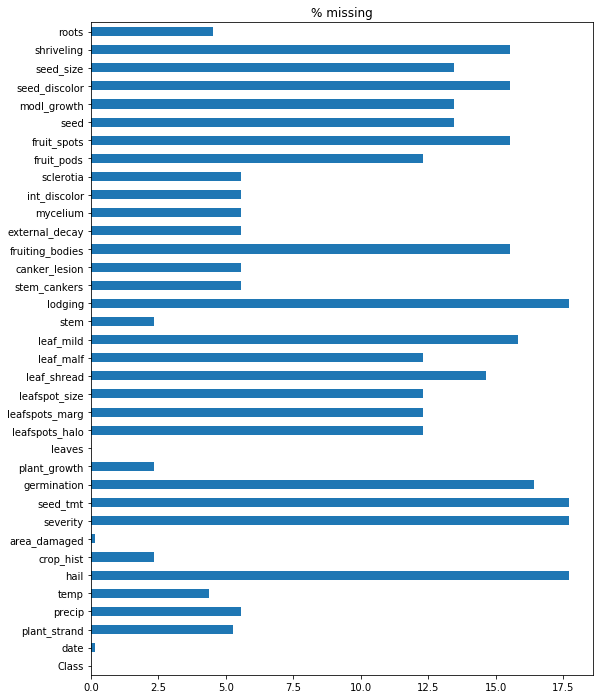

In [63]:
(soybean.isnull().sum() / soybean.shape[0] * 100).plot.barh(figsize=(9, 12), title='% missing')

In [94]:
soybean.isnull().sum().sort_values(ascending=False)

seed_tmt           121
severity           121
lodging            121
hail               121
germination        112
leaf_mild          108
fruit_spots        106
fruiting_bodies    106
seed_discolor      106
shriveling         106
leaf_shread        100
modl_growth         92
seed                92
seed_size           92
leafspots_halo      84
leafspots_marg      84
leafspot_size       84
leaf_malf           84
fruit_pods          84
stem_cankers        38
external_decay      38
mycelium            38
int_discolor        38
precip              38
sclerotia           38
canker_lesion       38
plant_strand        36
roots               31
temp                30
crop_hist           16
plant_growth        16
stem                16
area_damaged         1
date                 1
leaves               0
Class                0
dtype: int64

In [86]:
X = soybean.drop('Class', axis=1)
y = soybean['Class']

In [81]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import jaccard, pdist

In [95]:
corr = X.corr()

Y = linkage(corr, method='complete', metric='correlation')
Z = dendrogram(Y, no_plot=True)['leaves']
corr = corr.iloc[:, Z]
corr = corr.iloc[Z, :]

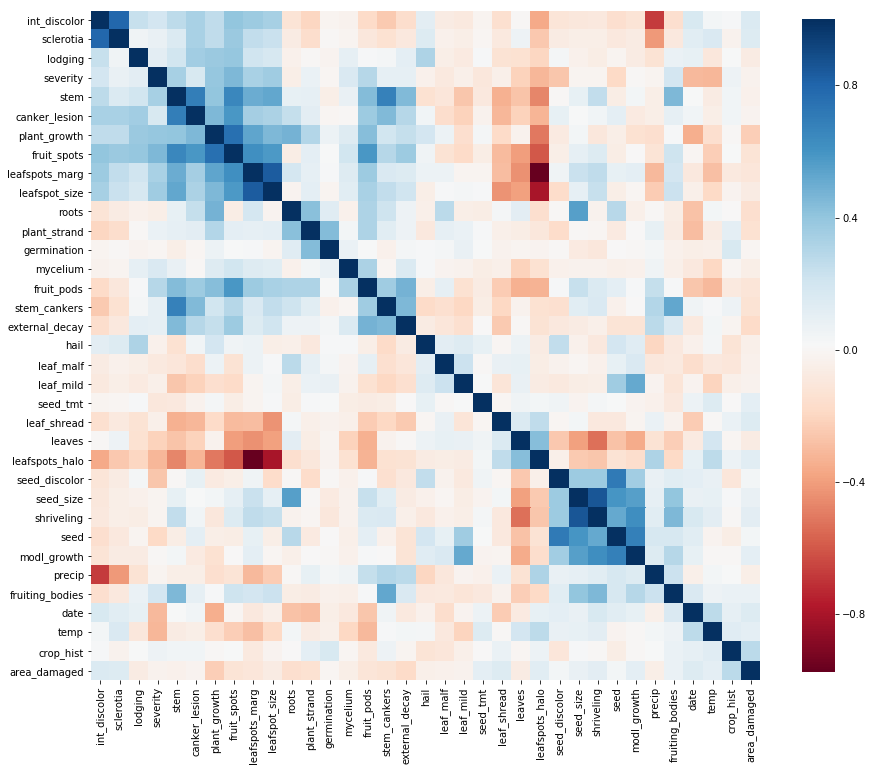

In [96]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, square=True, annot=False, fmt='.1f', cmap=plt.cm.RdBu, 
           ax=ax, cbar_kws={'shrink': .8})

In [105]:
class_with_missing = [c for c in np.unique(soybean['Class']) if soybean[soybean['Class']==c].isnull().sum().sum() > 0]
class_with_missing

['2-4-d-injury',
 'cyst-nematode',
 'diaporthe-pod-&-stem-blight',
 'herbicide-injury',
 'phytophthora-rot']

In [114]:
class_size = soybean.Class.value_counts()
class_size

brown-spot                     92
frog-eye-leaf-spot             91
alternarialeaf-spot            91
phytophthora-rot               88
anthracnose                    44
brown-stem-rot                 44
bacterial-blight               20
charcoal-rot                   20
purple-seed-stain              20
diaporthe-stem-canker          20
powdery-mildew                 20
downy-mildew                   20
rhizoctonia-root-rot           20
bacterial-pustule              20
phyllosticta-leaf-spot         20
2-4-d-injury                   16
diaporthe-pod-&-stem-blight    15
cyst-nematode                  14
herbicide-injury                8
Name: Class, dtype: int64

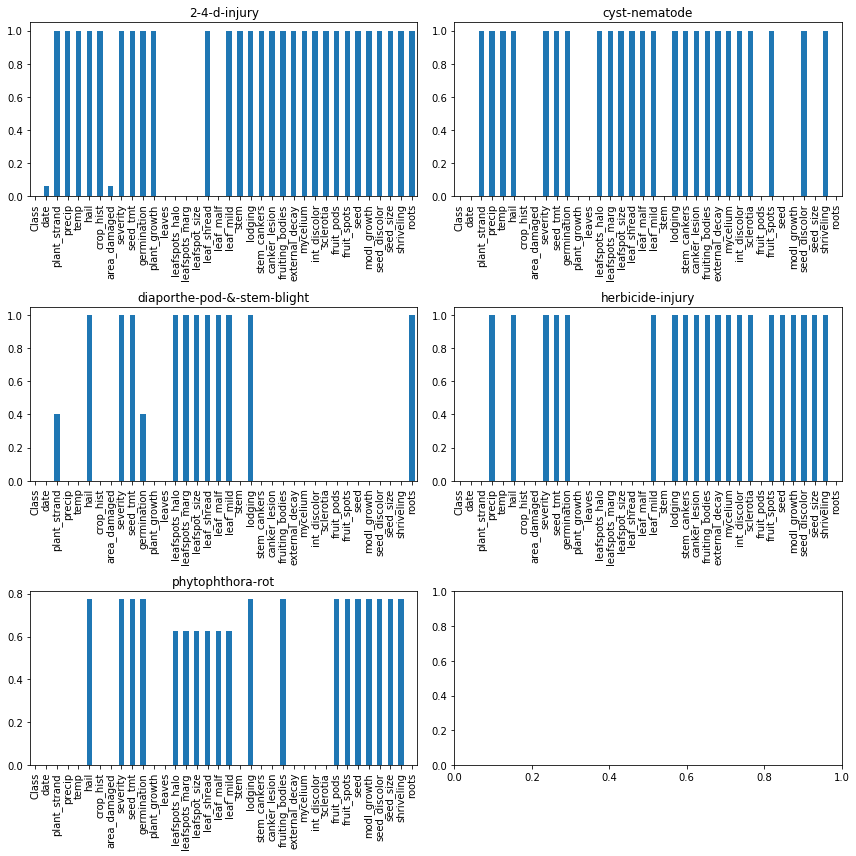

In [113]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for c, axi in zip(class_with_missing, ax.flat):
    (soybean[soybean['Class']==c].isnull().sum() / class_size[c]).plot.bar(ax=axi, title=c)
    
fig.tight_layout()

In [115]:
missing_df = pd.DataFrame(index=soybean.columns)
for c, axi in zip(class_with_missing, ax.flat):
    missing_df[c] = soybean[soybean['Class']==c].isnull().sum() / class_size[c]

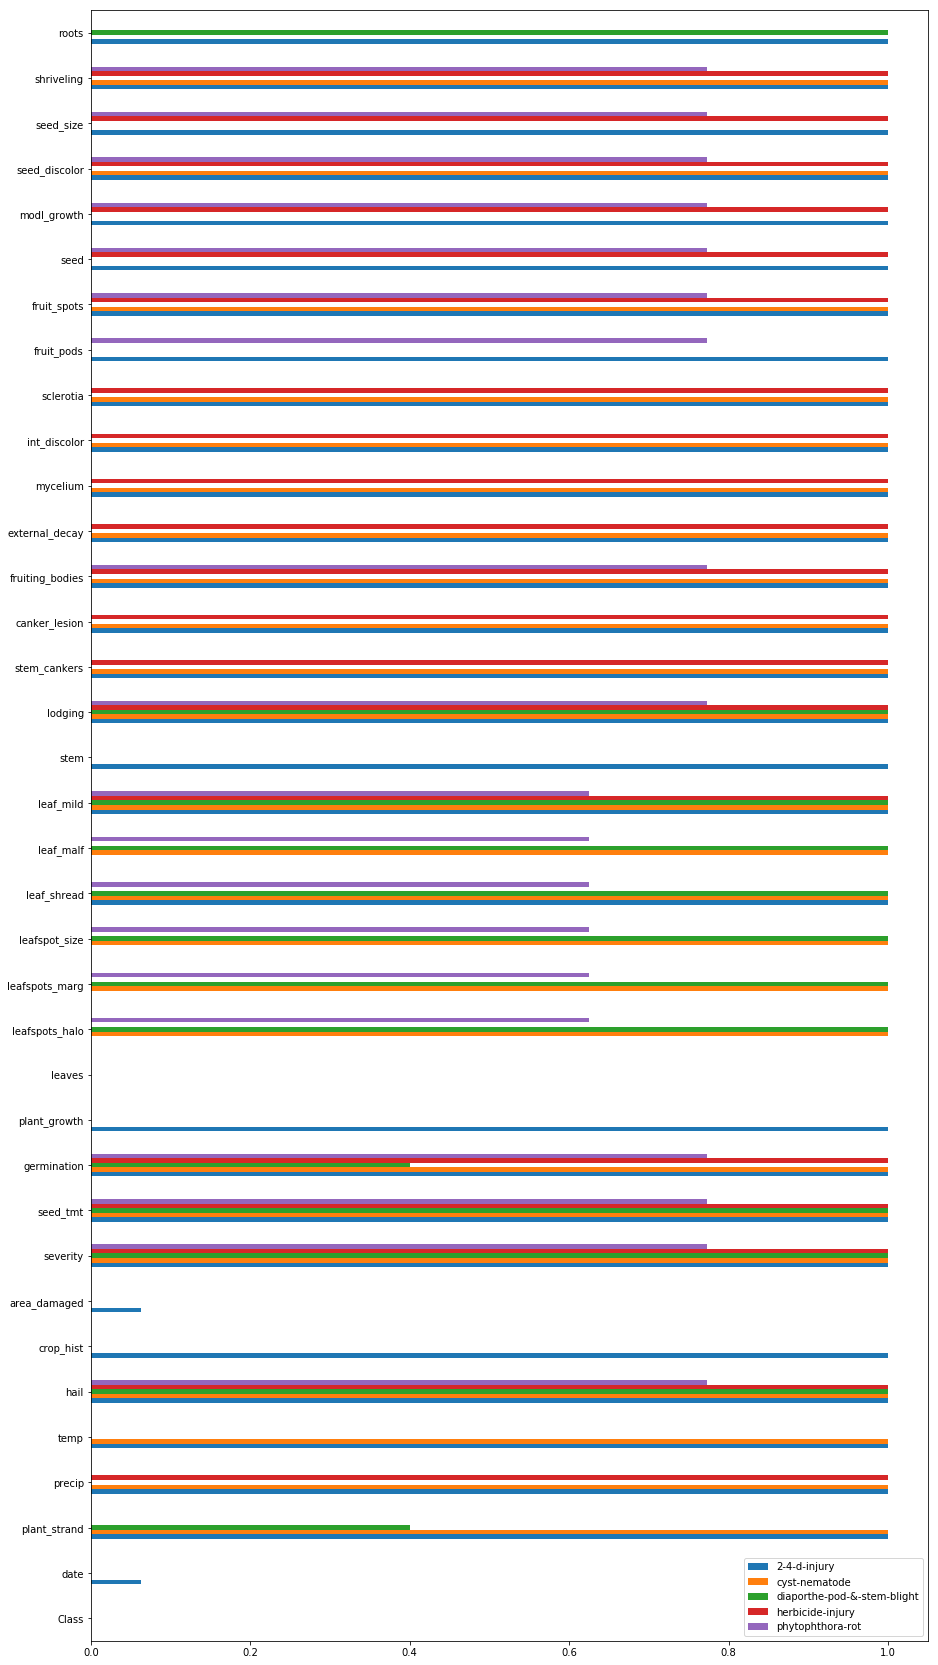

In [119]:
missing_df.plot.barh(figsize=(15, 30))

In [126]:
soybean.loc[soybean.Class=='2-4-d-injury', 'area_damaged']

302    NaN
357    1.0
358    0.0
359    1.0
360    2.0
361    3.0
362    0.0
363    2.0
364    3.0
365    0.0
366    1.0
367    2.0
368    3.0
369    0.0
370    1.0
371    2.0
Name: area_damaged, dtype: float64

In [125]:
soybean.loc[soybean.Class=='2-4-d-injury', 'date']

302    NaN
357    5.0
358    0.0
359    1.0
360    2.0
361    3.0
362    4.0
363    6.0
364    0.0
365    1.0
366    2.0
367    3.0
368    4.0
369    5.0
370    6.0
371    0.0
Name: date, dtype: float64

In [138]:
soybean.iloc[302].isnull().sum()

30

In [133]:
soybean.isnull().sum(axis=1).sort_values(ascending=False).value_counts().sort_index()

0     562
11      9
13     19
19     55
20      8
24     14
28     15
30      1
dtype: int64

In [140]:
soybean.loc[soybean.isnull().sum(axis=1)==28, :].T

,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371
Class,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury,2-4-d-injury
date,5,0,1,2,3,4,6,0,1,2,3,4,5,6,0
plant_strand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
crop_hist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
area_damaged,1,0,1,2,3,0,2,3,0,1,2,3,0,1,2
severity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seed_tmt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
soybean.loc[soybean.isnull().sum(axis=1)==24, :].T

,296,297,298,299,300,301,349,350,351,352,353,354,355,356
Class,cyst-nematode,cyst-nematode,cyst-nematode,cyst-nematode,cyst-nematode,cyst-nematode,cyst-nematode,cyst-nematode,cyst-nematode,cyst-nematode,cyst-nematode,cyst-nematode,cyst-nematode,cyst-nematode
date,2,3,4,3,3,4,2,3,4,2,3,4,4,3
plant_strand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
crop_hist,2,3,3,2,2,2,1,2,1,2,2,3,3,3
area_damaged,1,2,2,1,1,1,1,2,1,2,1,2,1,2
severity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seed_tmt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
pd.DataFrame({'drop': soybean.dropna().Class.value_counts(), 'no drop': soybean.Class.value_counts()})

,drop,no drop
2-4-d-injury,NaN,16
alternarialeaf-spot,91.0,91
anthracnose,44.0,44
bacterial-blight,20.0,20
bacterial-pustule,20.0,20
brown-spot,92.0,92
brown-stem-rot,44.0,44
charcoal-rot,20.0,20
cyst-nematode,NaN,14
diaporthe-pod-&-stem-blight,NaN,15


In [142]:
soybean.isnull().sum()

Class                0
date                 1
plant_strand        36
precip              38
temp                30
hail               121
crop_hist           16
area_damaged         1
severity           121
seed_tmt           121
germination        112
plant_growth        16
leaves               0
leafspots_halo      84
leafspots_marg      84
leafspot_size       84
leaf_shread        100
leaf_malf           84
leaf_mild          108
stem                16
lodging            121
stem_cankers        38
canker_lesion       38
fruiting_bodies    106
external_decay      38
mycelium            38
int_discolor        38
sclerotia           38
fruit_pods          84
fruit_spots        106
seed                92
modl_growth         92
seed_discolor      106
seed_size           92
shriveling         106
roots               31
dtype: int64

In [149]:
X_nan_fill = X.drop(302, axis=0).fillna(-1).astype(str)
X_nan_fill.shape

(681, 35)

In [150]:
pd.get_dummies(X_nan_fill).shape

(681, 131)

### ex 3.3: BloodBrain

In [162]:
data = pd.read_csv('data/BloodBrain/bbbDescr.csv', index_col=0)
outcome = pd.read_csv('data/BloodBrain/logBBB.csv', index_col=0)
outcome.columns = ['target']

In [156]:
data.head()

,tpsa,nbasic,negative,vsa_hyd,a_aro,weight,peoe_vsa.0,peoe_vsa.1,peoe_vsa.2,peoe_vsa.3,...,scaa3,ctdh,ctaa,mchg,achg,rdta,n_sp2,n_sp3,o_sp2,o_sp3
1,12.030000,1,0,167.06700,0,156.293,76.94749,43.44619,0.00000,0.000000,...,-0.0093,1,1,0.9241,0.9241,1.0000,0.000000,6.0255,0.000000,0.000000
2,49.330002,0,0,92.64243,6,151.165,38.24339,25.52006,0.00000,8.619013,...,-0.0754,2,2,1.2685,1.0420,1.0000,0.000000,6.5681,32.010201,33.613499
3,50.529999,1,0,295.16700,15,366.485,58.05473,124.74020,21.65084,8.619013,...,-0.0303,1,4,1.2562,1.2562,0.2500,26.973301,10.8567,0.000000,27.545099
4,37.389999,0,0,319.11220,15,382.552,62.23933,124.74020,13.19232,21.785640,...,-0.0240,1,3,1.1962,1.1962,0.3333,21.706499,11.0017,0.000000,15.131600
5,37.389999,1,0,299.65800,12,326.464,74.80064,118.04060,33.00190,0.000000,...,-0.0255,1,3,1.2934,1.2934,0.3333,24.206100,10.8109,0.000000,15.133300


In [164]:
data.shape, outcome.shape

((208, 134), (208, 1))

In [170]:
(data.dtypes == float).sum(), (data.dtypes==int).sum()

(118, 16)

In [171]:
int_cols = data.columns[data.dtypes==int]
float_cols = data.columns[data.dtypes==float]

In [176]:
data.isnull().sum().sum()

0

In [174]:
data[int_cols].applymap(str).describe(include=['O']).T

,count,unique,top,freq
nbasic,208,2,0,132
negative,208,2,0,207
a_aro,208,12,12,63
a_acc,208,7,2,63
a_acid,208,3,0,201
a_base,208,6,1,85
rotatablebonds,208,14,2,27
nocount,208,10,3,51
hbdnr,208,7,2,83
rule.of.5violations,208,4,0,165


In [175]:
data[float_cols].applymap(str).describe(include=['O']).T

,count,unique,top,freq
tpsa,208,128,36.419998,15
vsa_hyd,208,194,156.2279,3
weight,208,191,180.167,3
peoe_vsa.0,208,164,8.936826,5
peoe_vsa.1,208,155,56.05296,6
peoe_vsa.2,208,66,0.0,63
peoe_vsa.3,208,38,0.0,83
peoe_vsa.4,208,16,0.0,134
peoe_vsa.5,208,11,0.0,150
peoe_vsa.6,208,21,8.619013,48


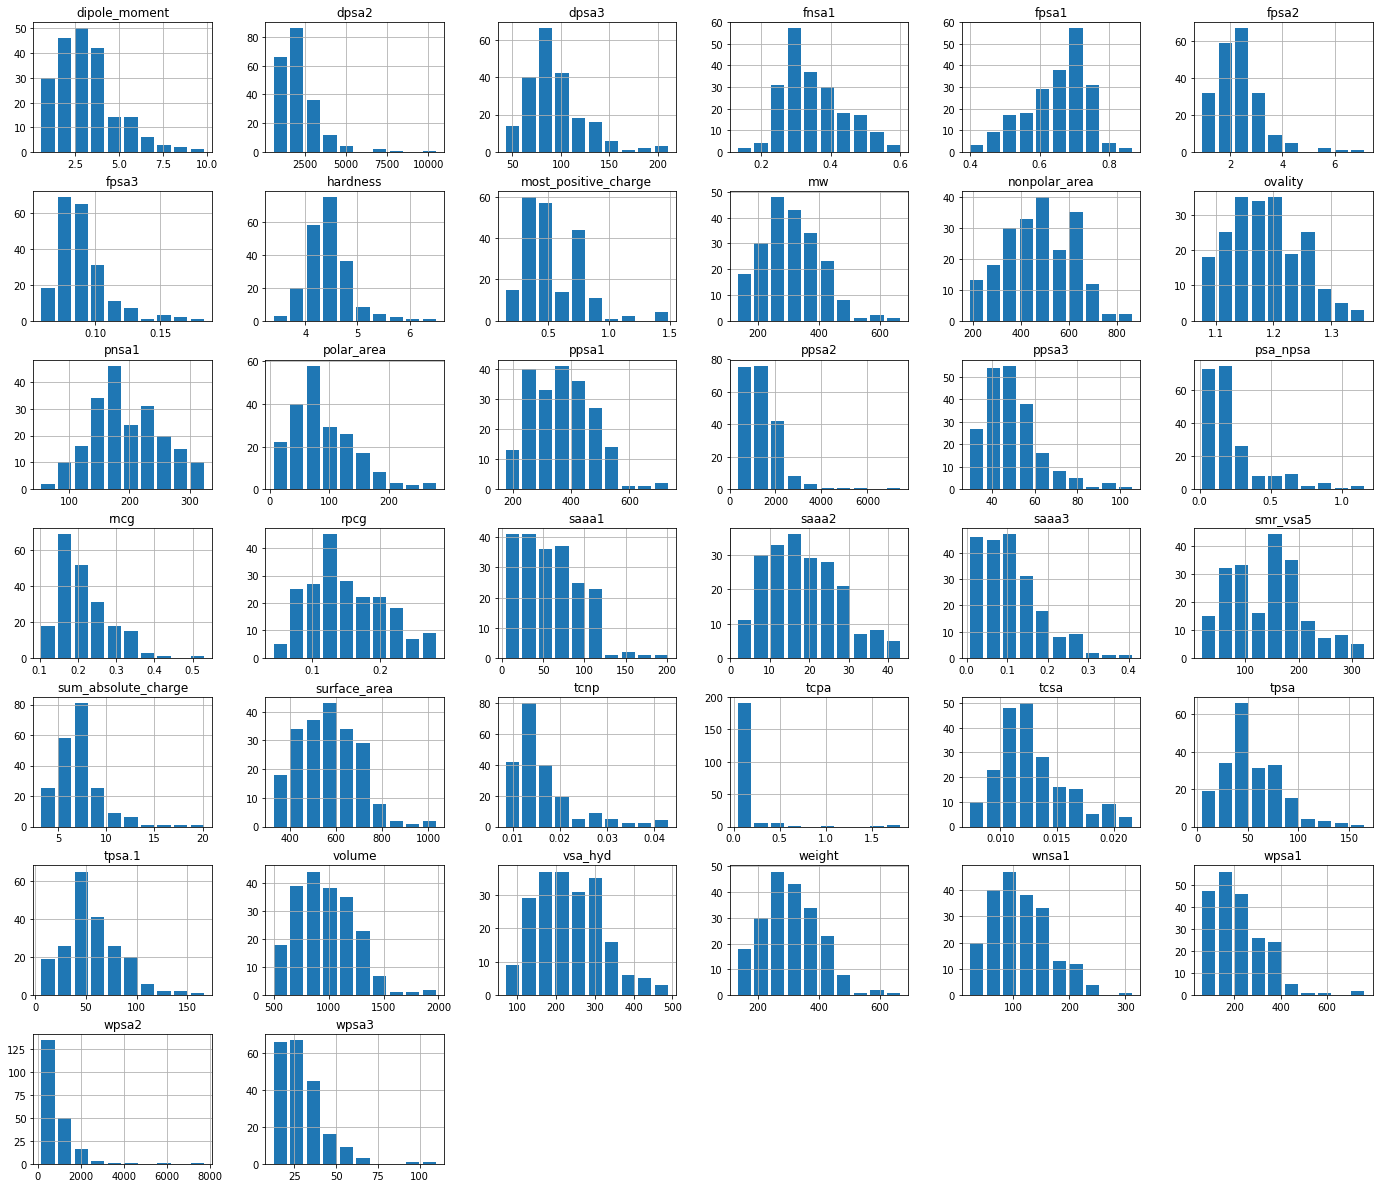

In [186]:
valid_boxcox = [c for c in float_cols if data[c].min() > 0]

_ = data[valid_boxcox].hist(figsize=(24, 21), rwidth=.8)

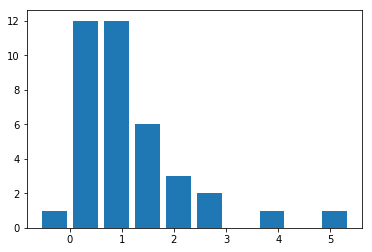

In [187]:
_ = plt.hist(skew(data[valid_boxcox]), rwidth=.8)

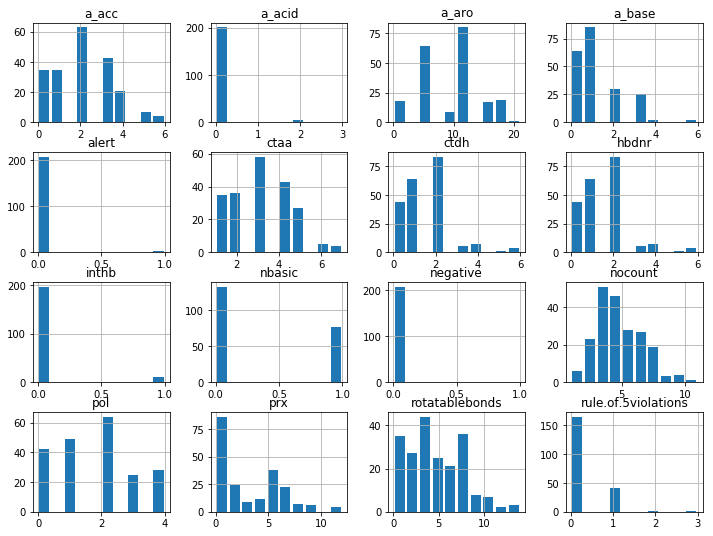

In [189]:
_ = data[int_cols].hist(figsize=(12, 9), rwidth=.8)

In [190]:
n_samples = len(data)

low_cardinality = [c for c in data.columns if data[c].nunique()/n_samples < .1]
low_cardinality

['nbasic',
 'negative',
 'a_aro',
 'peoe_vsa.4',
 'peoe_vsa.5',
 'peoe_vsa.2.1',
 'peoe_vsa.3.1',
 'peoe_vsa.4.1',
 'peoe_vsa.5.1',
 'a_acc',
 'a_acid',
 'a_base',
 'vsa_acid',
 'vsa_base',
 'vsa_don',
 'vsa_pol',
 'slogp_vsa6',
 'frac.anion7.',
 'rotatablebonds',
 'nocount',
 'hbdnr',
 'rule.of.5violations',
 'alert',
 'prx',
 'ub',
 'pol',
 'inthb',
 'ctdh',
 'ctaa',
 'rdta']

In [191]:
high_ratio = []
for c in low_cardinality:
    a = pd.value_counts(data[c]).sort_values(ascending=False)
    if a.iloc[0] / a.iloc[1] > 20:
        high_ratio.append(c)
high_ratio

['negative',
 'peoe_vsa.2.1',
 'peoe_vsa.3.1',
 'a_acid',
 'vsa_acid',
 'frac.anion7.',
 'alert']

Text(0.5,0.98,'Degenerate Distributions')

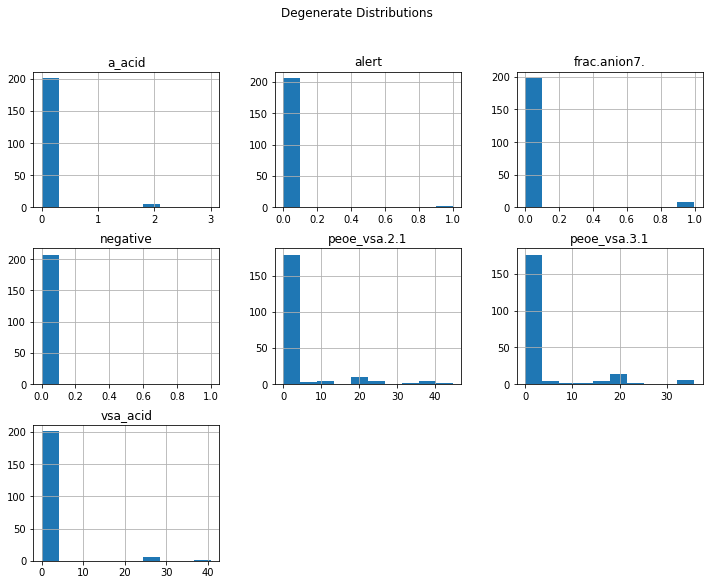

In [196]:
_ = data[high_ratio].hist(figsize=(12, 9))

fig = plt.gcf()
fig.suptitle("Degenerate Distributions")


In [204]:
corr = data.corr()

Y = linkage(corr, method='complete', metric='correlation')
Z = dendrogram(Y, no_plot=True)['leaves']
corr = corr.iloc[:, Z]
corr = corr.iloc[Z, :]

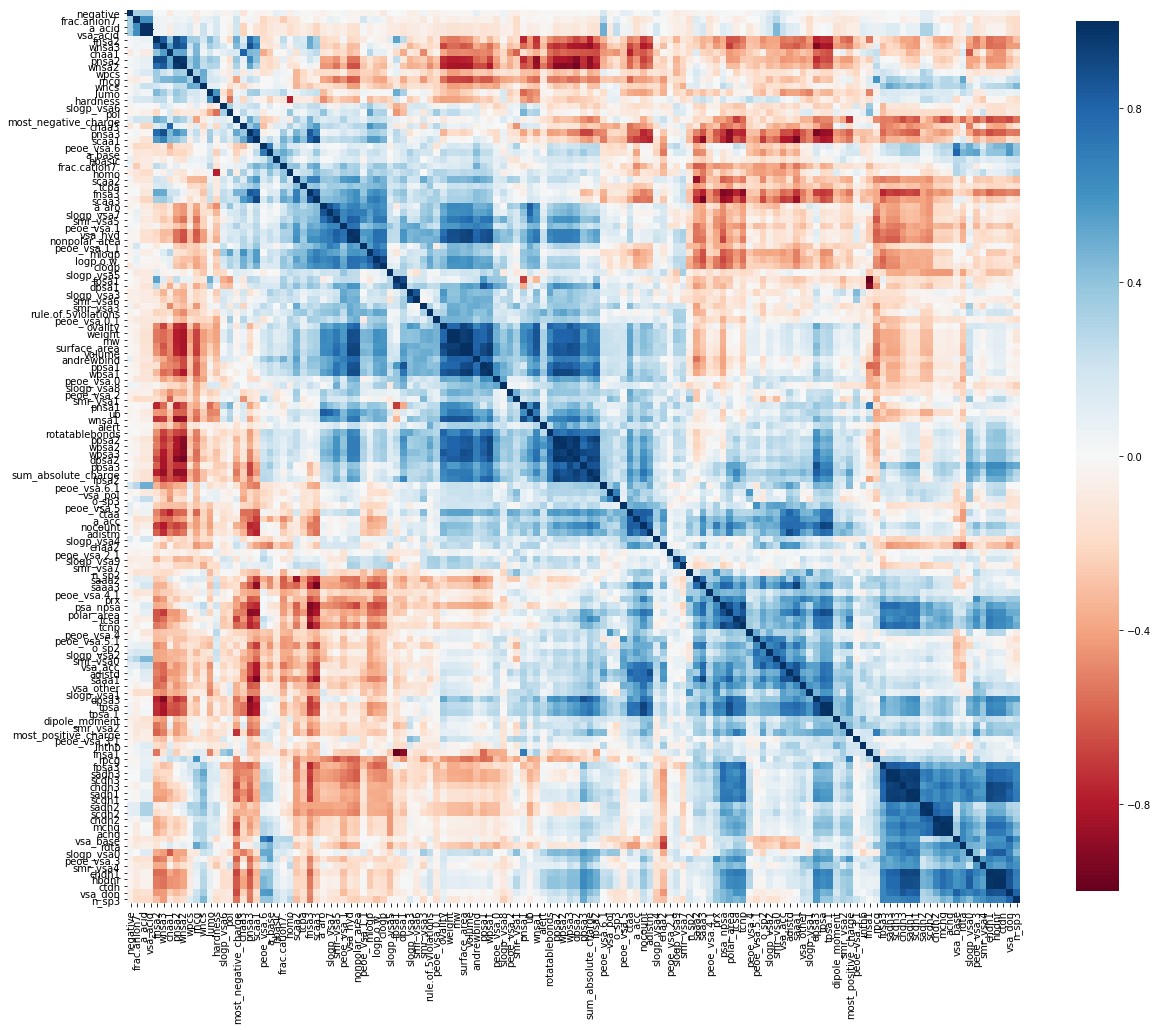

In [206]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, annot=False, square=True, cmap=plt.cm.RdBu, cbar_kws={'shrink': .8}, 
            vmax=1, vmin=-1, ax=ax, xticklabels=True, yticklabels=True)

In [208]:
strong_corr = []
for i, c1 in enumerate(corr.columns):
    for c2 in corr.columns[i+1:]:
        if corr.loc[c1, c2] > .75:
            strong_corr.append((c1, c2, corr.loc[c1, c2]))
len(strong_corr)

254

In [213]:
sc = StandardScaler()
pca = PCA()

data_pca = pca.fit_transform(sc.fit_transform(data))

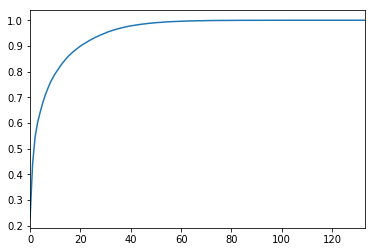

In [219]:
pd.Series(pca.explained_variance_ratio_.cumsum()).plot()

In [220]:
(pca.explained_variance_ratio_.cumsum() < .95).sum()

30

In [221]:
(pca.explained_variance_ratio_.cumsum() < .99).sum()

50